# Data Analysis for Neural Networks Paper
## Preparation
### Import Dependencies

In [2]:
import os
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import seaborn as sns
#from RL_utils import *
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.patches as mpatches
from itertools import combinations
from scipy.spatial import distance
from scipy.ndimage.filters import gaussian_filter1d

### Load Data

In [3]:
folder_name = '3999_16.100'
path = './Results/TowerTraining/Recordings/Standard/'+folder_name+'/'
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/'

obs = np.load(path+'visobs.npy', mmap_mode='r')
vec = np.load(path+'vecobs.npy')

rew = np.load(path+'rewards.npy')

encA = np.load(path+'encodings.npy')
encA = encA.reshape(encA.shape[0],encA.shape[-1])[:,:256]
#encR = np.load(path+'randenc.npy')[:,:256]#for random activations
encAE = np.load(path+'AEActAdam.npy')
encAE = encAE.reshape(encAE.shape[0],encAE.shape[-1])[:,:256]
encC = np.load(path+'ClassActAdamScaled.npy')

actionL = np.load(path+'actions.npy')
val = np.load(path+'values.npy')
outAE = np.load(path+'AEOutAdam.npy')
outClass = np.load(path+'ClassOutAdamScaled.npy')

doors = np.load(path+'doors.npy')
Rewards = np.load(path+'reward_per.npy')

hand_l = pd.read_csv(path+'HandLabels.csv')
label_test = np.zeros(encA.shape[0])
label_test = np.array(hand_l['Label'])

### General Functions Needed

In [3]:
def getClusterVariance(cluster,data,num_cluster):
    between_var = np.var(data,axis=0)
    within_var = []
    for i in range(num_cluster):
        which = np.where(cluster==i)
        within_var.append(np.var(data[which],axis=0))
    b = np.mean(between_var)
    w = np.zeros(num_cluster)
    for i in range(num_cluster):
        w[i] = np.mean(within_var[i])
    return between_var, within_var, b, w
def getDistances(points):
    distances = [distance.euclidean(p1, p2) for p1, p2 in combinations(points, 2)]
    return distances
def getAcrossD(c1,c2):
    comb = [(x,y) for x in c1 for y in c2]
    distances = [distance.euclidean(p1, p2) for p1, p2 in comb]
    return distances
def getCorDistances(points):
    distances = [distance.correlation(p1, p2) for p1, p2 in combinations(points, 2)]
    return distances
def getAcrossCorD(c1,c2):
    comb = [(x,y) for x in c1 for y in c2]
    distances = [distance.correlation(p1, p2) for p1, p2 in comb]
    return distances
def where_array_equal(a,b):
    equal = np.zeros(a.shape[0])
    for i,arr in enumerate(a):
        if np.array_equal(arr,b):
            equal[i] = 1
    return equal

### Some Precalculations

In [4]:
w = where_array_equal(actionL[:,0],np.unique(actionL[:,0],axis=0)[3])

combs = np.unique(actionL[:,0],axis=0)
a_vec = np.zeros((combs.shape[0],actionL.shape[0]))
for i,c in enumerate(combs):
    a_vec[i] = where_array_equal(actionL[:,0],c)
#print(a_vec.shape)    

all_a_comb = np.zeros(actionL.shape[0])
for i in range(actionL.shape[0]):
    if a_vec[0][i] == 1:
        all_a_comb[i] = 0#[1, 0, 0, 1] Forward, Turn right
    elif a_vec[3][i] == 1:
        all_a_comb[i] = 1#[1, 1, 0, 1] Forward, Camera Left, Turn Right
    elif a_vec[4][i] == 1:
        all_a_comb[i] = 2#[1, 1, 0, 2] Forward, Camera Left, Turn Left
    elif a_vec[6][i] == 1:
        all_a_comb[i] = 3#[1, 2, 0, 1] Forward, Camera Right, Turn Right
    elif a_vec[13][i] == 1:
        all_a_comb[i] = 4#[2, 2, 0, 1] Backward, Camera Right, Turn Right
    else:
        all_a_comb[i] = 5#Anything else
actions = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']

## Analysis of Activation Patterns
### Sparseness of Activations

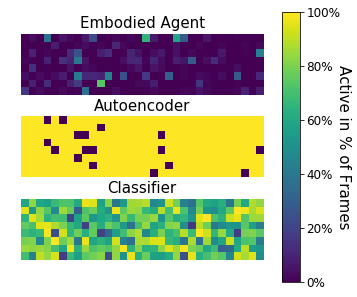

In [5]:
perActA = np.sum((encA)>0,axis=0)/encA.shape[0]
perActAE = np.sum((encAE)>0,axis=0)/encAE.shape[0]
perActC = np.sum((encC)>0,axis=0)/encC.shape[0]
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(3, 1, 1)
im2 = plt.imshow(perActA.reshape(8,32), vmin=0, vmax=1)
plt.title('Embodied Agent',fontsize=15)
plt.axis('off')
ax2 = fig.add_subplot(3, 1, 2)
im1 = plt.imshow(perActAE.reshape(8,32), vmin=0, vmax=1)
plt.title('Autoencoder',fontsize=15)
plt.axis('off')
ax3 = fig.add_subplot(3, 1, 3)
im3 = plt.imshow(perActC.reshape(8,32), vmin=0, vmax=1)
plt.title('Classifier',fontsize=15)
plt.axis('off')
#plt.suptitle('Visual Encoding',fontsize=18)
fig.subplots_adjust(right=0.8,top=0.85,bottom=0.2)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.75])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.ax.set_yticklabels(['0%', '20%', '40%','60%','80%','100%'],fontsize=12)
cbar.set_label('Active in % of Frames', rotation=270,fontsize=15, labelpad=10)

#plt.show()
plt.savefig(figure_path+'PerAct.eps', bbox_inches='tight', dpi=300)

In [6]:
print("Embodied Agent:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encA[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encA[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encA[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encA[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encA[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encA[:,:256])>0,axis=0)/encA.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encA[:,256:])>0,axis=0)/encA.shape[0]*100

print("\nAutoencoder:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encAE[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encAE[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encAE[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encAE[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encAE[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encAE[:,:256])>0,axis=0)/encAE.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encAE[:,256:])>0,axis=0)/encAE.shape[0]*100

print("\nClassifier:")
print("Average number of neurons active per frame (visual): "+str(np.mean(np.sum(encC[:,:256]>0,axis=1)))+" (min="+str(np.min(np.sum(encC[:,:256]>0,axis=1)))+
      " max="+str(np.max(np.sum(encC[:,:256]>0,axis=1)))+" var="+str(np.round(np.var(np.sum(encC[:,:256]>0,axis=1)),3))+")")
print("This is "+str(np.round(np.mean(np.sum(encC[:,:256]>0,axis=1))/256*100,3))+"% of all neurons.")
visActPer = np.sum((encC[:,:256])>0,axis=0)/encC.shape[0]*100
print("In the visual encoding "+str(np.sum(visActPer>0))+" of the 256 neurons are active in at least 1 frame (="+
     str(np.round(np.sum(visActPer>0)/256*100,3))+"%), "+str(np.sum(visActPer>40))+" neurons are active in more than 40% of the frames (="+
     str(np.round(np.sum(visActPer>40)/256*100,3))+"%). "+str(np.sum(visActPer==0))+" neurons are never active (="+str(np.round(np.sum(visActPer==0)/256*100,3))+
     "%). The most active neuron is active in "+str(np.max(visActPer))+"% of the frames.")
vecActPer = np.sum((encC[:,256:])>0,axis=0)/encC.shape[0]*100

Embodied Agent:
Average number of neurons active per frame (visual): 11.8805 (min=3 max=35 var=17.891)
This is 4.641% of all neurons.
In the visual encoding 173 of the 256 neurons are active in at least 1 frame (=67.578%), 7 neurons are active in more than 40% of the frames (=2.734%). 83 neurons are never active (=32.422%). The most active neuron is active in 74.15% of the frames.

Autoencoder:
Average number of neurons active per frame (visual): 238.99725 (min=238 max=239 var=0.003)
This is 93.358% of all neurons.
In the visual encoding 239 of the 256 neurons are active in at least 1 frame (=93.359%), 239 neurons are active in more than 40% of the frames (=93.359%). 17 neurons are never active (=6.641%). The most active neuron is active in 100.0% of the frames.

Classifier:
Average number of neurons active per frame (visual): 178.55675 (min=125 max=220 var=277.592)
This is 69.749% of all neurons.
In the visual encoding 256 of the 256 neurons are active in at least 1 frame (=100.0%), 2

### Compare Activations of Single Neurons

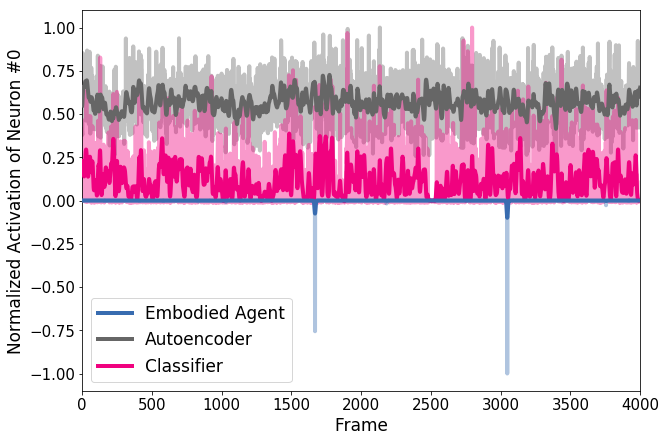

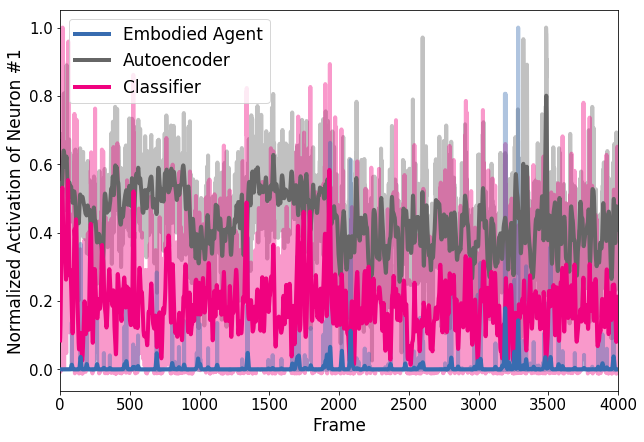

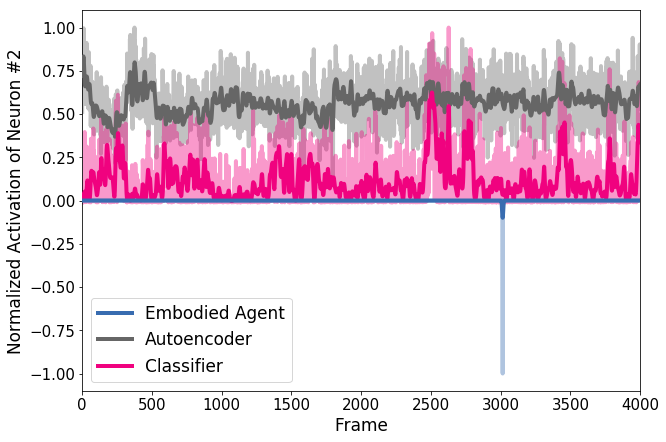

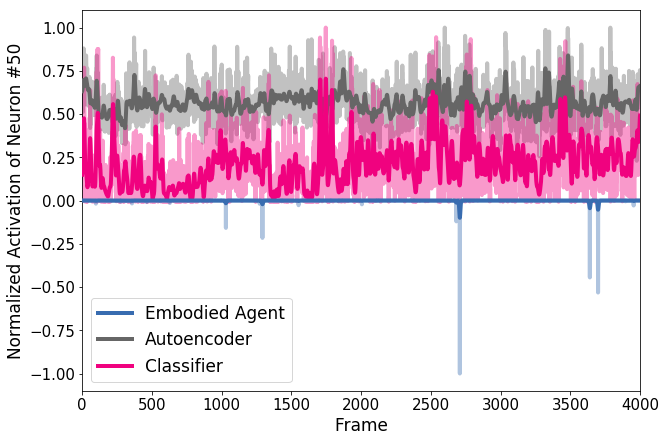

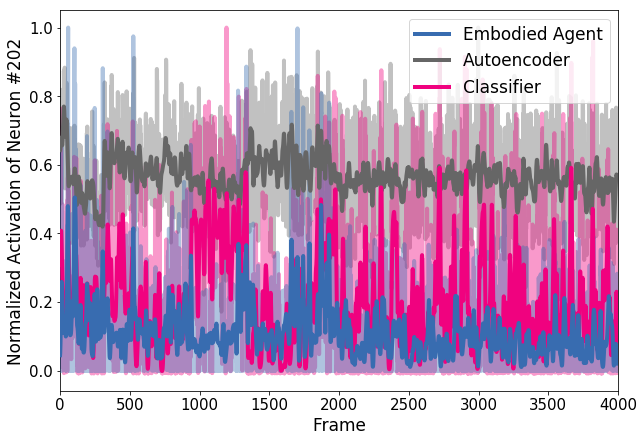

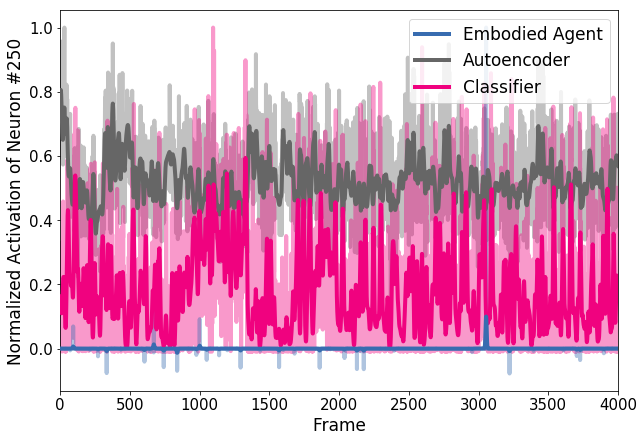

In [7]:
for n in [0,1,2,50,202,250]:
    plt.figure(figsize=(10,7))
    ysmoothedA = gaussian_filter1d(encA[:,n]/np.max(np.abs(encA[:,n])), sigma=4)
    plt.plot(ysmoothedA,color=sns.color_palette("Accent", n_colors=8)[4],lw=4,zorder=6)

    ysmoothedAE = gaussian_filter1d(encAE[:,n]/np.max(np.abs(encAE[:,n])), sigma=4)
    plt.plot(ysmoothedAE,color=sns.color_palette("Accent", n_colors=8)[7],lw=4,zorder=4)

    ysmoothedC = gaussian_filter1d(encC[:,n]/np.max(np.abs(encC[:,n])), sigma=4)
    plt.plot(ysmoothedC,color=sns.color_palette("Accent", n_colors=8)[5],lw=4,zorder=4)

    plt.plot(encA[:,n]/np.max(np.abs(encA[:,n])),color=sns.color_palette("Accent", n_colors=8)[4],lw=4,zorder=3,alpha=0.4)
    plt.plot(encAE[:,n]/np.max(np.abs(encAE[:,n])),color=sns.color_palette("Accent", n_colors=8)[7],lw=4,alpha=0.4)
    plt.plot(encC[:,n]/np.max(np.abs(encC[:,n])),color=sns.color_palette("Accent", n_colors=8)[5],lw=4,alpha=0.4)

    plt.xlim([0,4000])
    plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Frame',fontsize=17)
    plt.ylabel('Normalized Activation of Neuron #'+str(n),fontsize=17)
    #plt.show()
    plt.savefig(figure_path+'NeuronActs/ActN'+str(n)+'.jpeg', bbox_inches='tight', dpi=300)


## Meaningfulness of Activations
### K-Means
#### Create Clusterings

In [8]:
num_cluster = 6
kmeansA = KMeans(n_clusters=num_cluster, random_state=0).fit(encA)
clusterA = kmeansA.predict(encA)

kmeansAE = KMeans(n_clusters=num_cluster, random_state=0).fit(encAE)
clusterAE = kmeansAE.predict(encAE)

kmeansC = KMeans(n_clusters=num_cluster, random_state=0).fit(encC)
clusterC = kmeansC.predict(encC)

#### Variance within Clusters

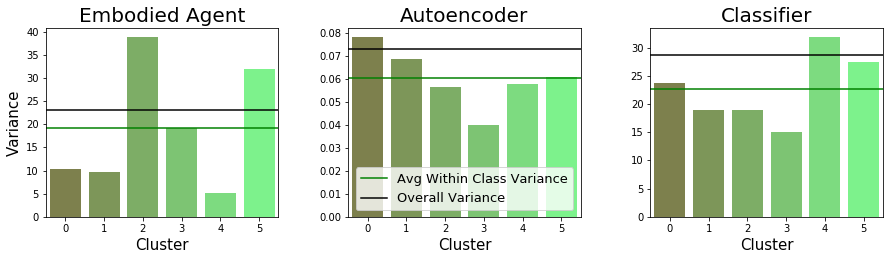

In [9]:
_,_,BA,WA = getClusterVariance(clusterA,encA,num_cluster)
_,_,BAE,WAE = getClusterVariance(clusterAE,encAE,num_cluster)
_,_,BC,WC = getClusterVariance(clusterC,encC,num_cluster)

plt.figure(figsize=(15,4))
plt.subplots_adjust(top=0.78,wspace=0.3)

plt.subplot(1,3,1)
plt.title('Embodied Agent',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WA),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WA)),np.mean(np.array(WA))],color='green')
plt.plot([-1,num_cluster],[BA,BA],color='black')
plt.xlim([-0.5,num_cluster-0.5])
#plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=10)
plt.xlabel('Cluster',fontsize=15)
plt.ylabel('Variance',fontsize=15)

plt.subplot(1,3,2)
plt.title('Autoencoder',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WAE),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WAE)),np.mean(np.array(WAE))],color='green')
plt.plot([-1,num_cluster],[BAE,BAE],color='black')
plt.xlim([-0.5,num_cluster-0.5])
plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=13,loc = 8)
plt.xlabel('Cluster',fontsize=15)
#plt.ylabel('Variance',fontsize=15)

plt.subplot(1,3,3)
plt.title('Classifier',fontsize=20)
plt.bar(np.linspace(0,num_cluster-1,num_cluster),np.array(WC),color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.plot([-1,num_cluster],[np.mean(np.array(WC)),np.mean(np.array(WC))],color='green')
plt.plot([-1,num_cluster],[BC,BC],color='black')
plt.xlim([-0.5,num_cluster-0.5])
#plt.legend(['Avg Within Class Variance','Overall Variance'],fontsize=10)
plt.xlabel('Cluster',fontsize=15)
#plt.ylabel('Variance',fontsize=15)
#plt.show()
plt.savefig(figure_path+'ClusterVar'+str(num_cluster)+'.eps', bbox_inches='tight',dpi=300)

#### Distribution of Frames in Clusters

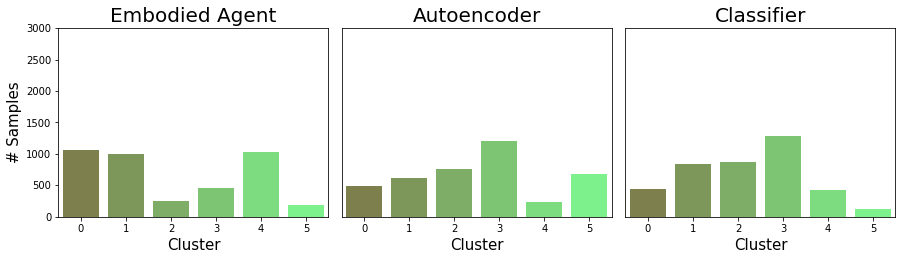

In [10]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(top=0.78,wspace=0.05)

plt.subplot(1,3,1)
plt.title('Embodied Agent',fontsize=20)
hA = np.histogram(clusterA,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hA[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.xlabel('Cluster',fontsize=15)
plt.ylabel('# Samples',fontsize=15)

plt.subplot(1,3,2)
plt.title('Autoencoder',fontsize=20)
hAE = np.histogram(clusterAE,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hAE[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.yticks([],[])
plt.xlabel('Cluster',fontsize=15)

plt.subplot(1,3,3)
plt.title('Classifier',fontsize=20)
hC = np.histogram(clusterC,bins=np.linspace(-0.5,num_cluster-0.5,num_cluster+1))
plt.bar(np.linspace(0,5,6),hC[0],color=[(0.49, 0.5+c*0.09, 0.3 + c*0.05)for c in range(6)])
plt.xlim([-0.5,num_cluster-0.5])
plt.ylim([0,3000])
plt.yticks([],[])
plt.xlabel('Cluster',fontsize=15)

#plt.show()
plt.savefig(figure_path+'ClusterCount'+str(num_cluster)+'.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Embodied Agent

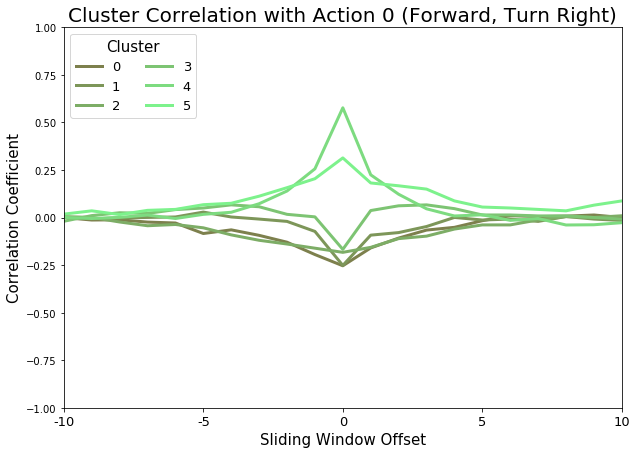

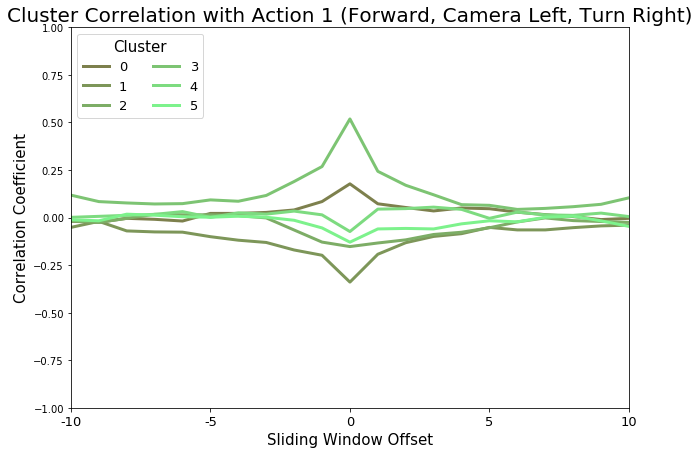

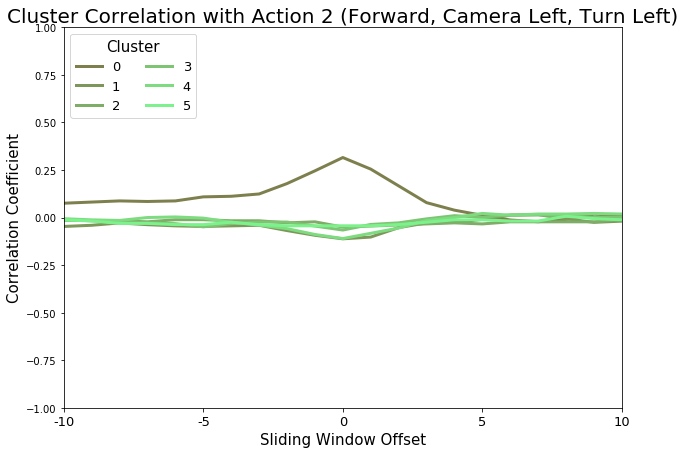

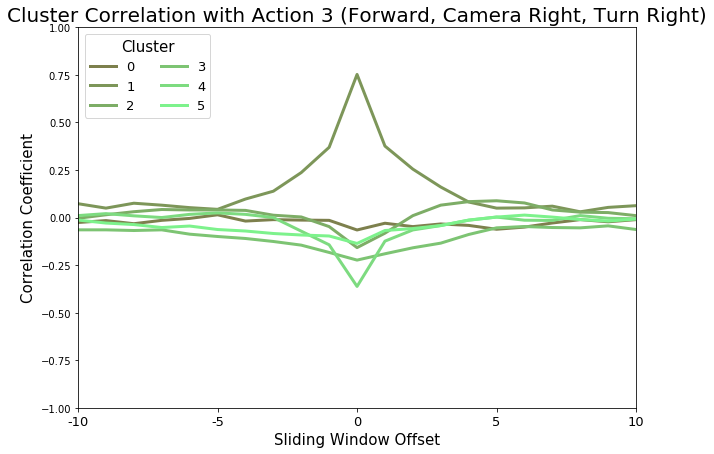

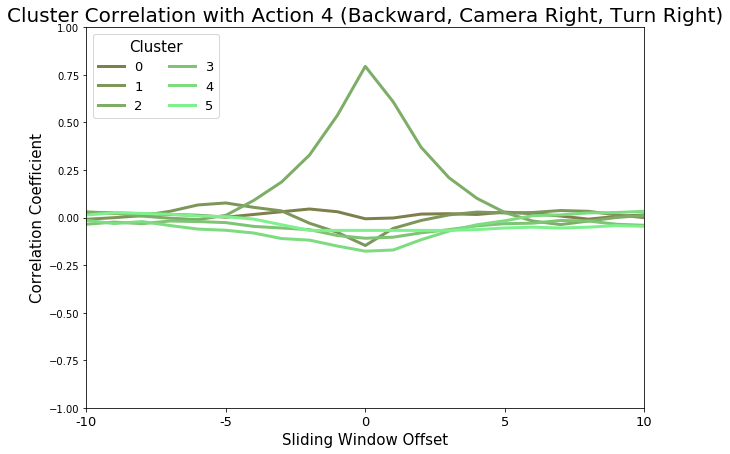

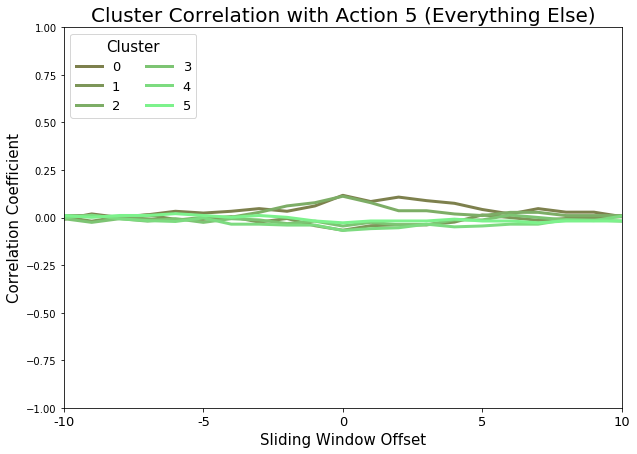

In [11]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corVal=np.zeros((6,num_cluster))
cormaxA = 0
corminA = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxA:cormaxA = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminA:corminA = np.min(corrs[:,c])
        corVal[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/A_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [12]:
dfA = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfA = dfA.append({'Action':actions[a],'cluster':int(c),'correlation':corVal[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Autoencoder

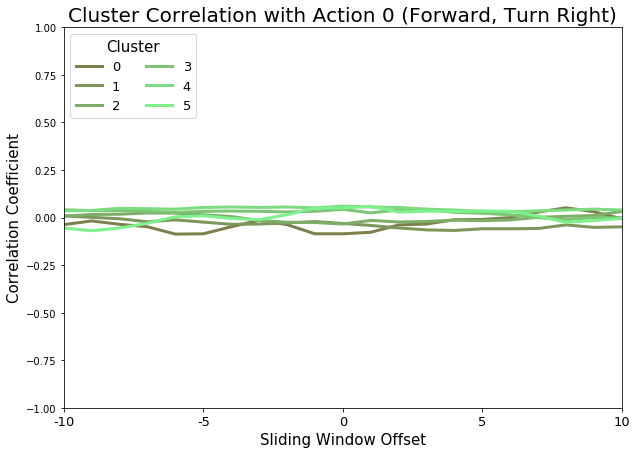

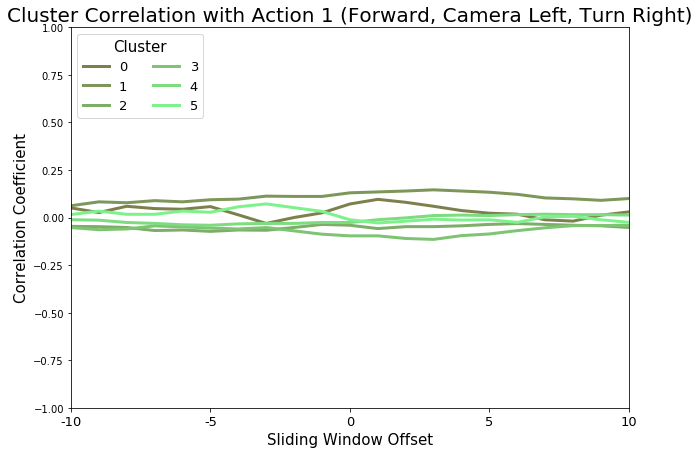

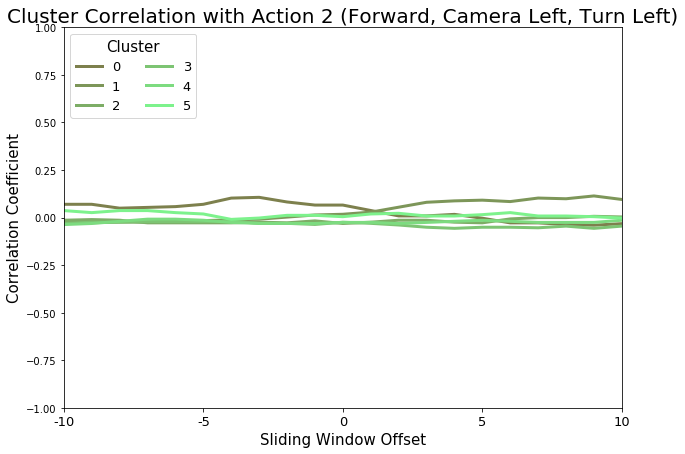

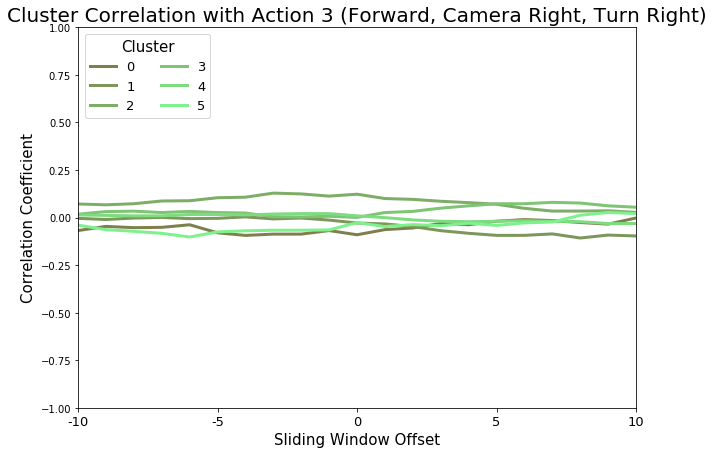

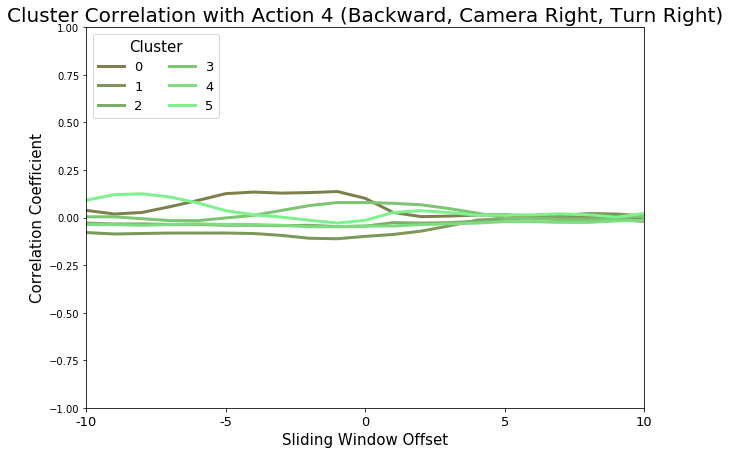

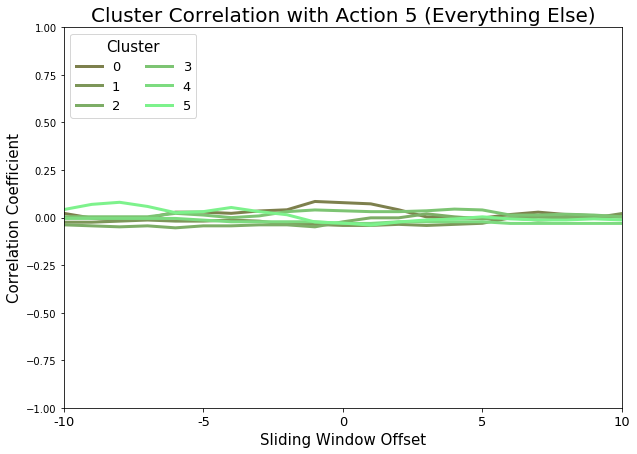

In [13]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corValAE=np.zeros((6,num_cluster))
cormaxAE = 0
corminAE = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxAE:cormaxAE = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminAE:corminAE = np.min(corrs[:,c])
        corValAE[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/AE_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [14]:
dfAE = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfAE = dfAE.append({'Action':actions[a],'cluster':int(c),'correlation':corValAE[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Classifier

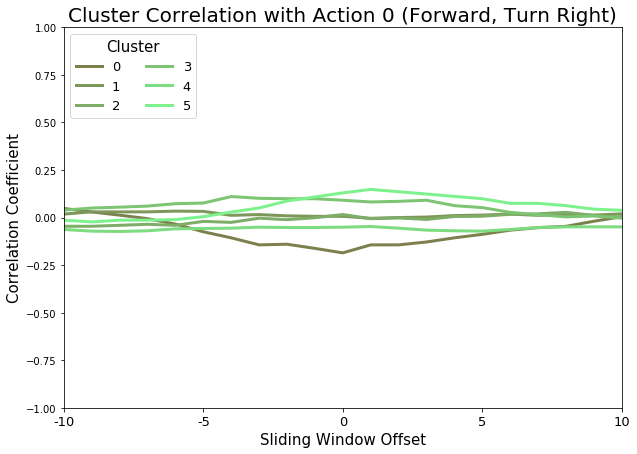

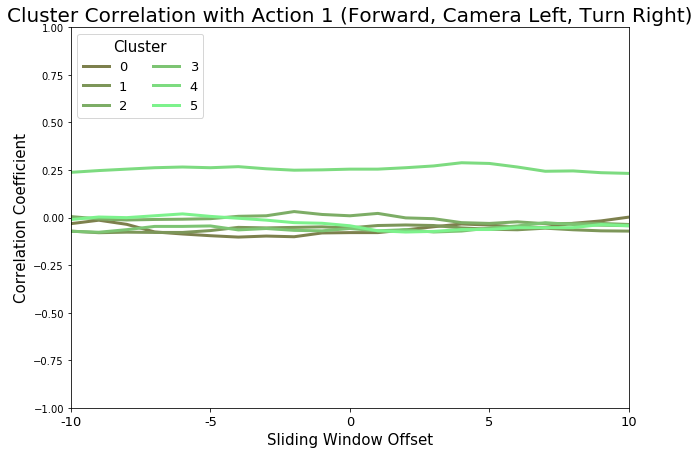

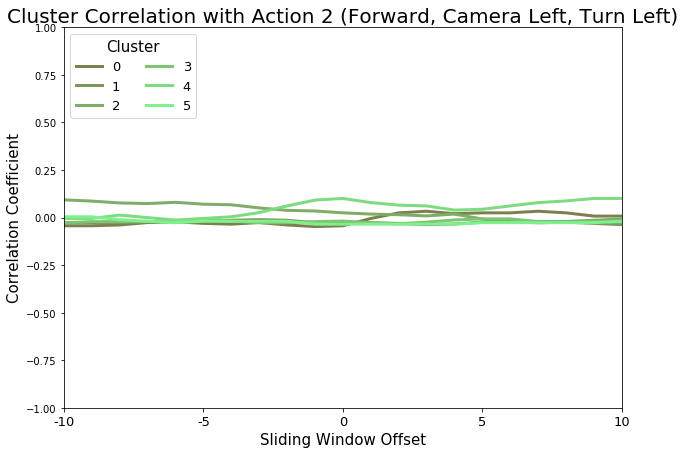

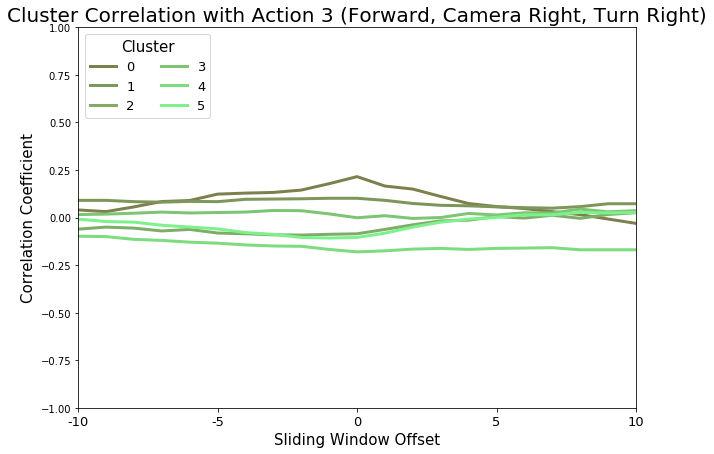

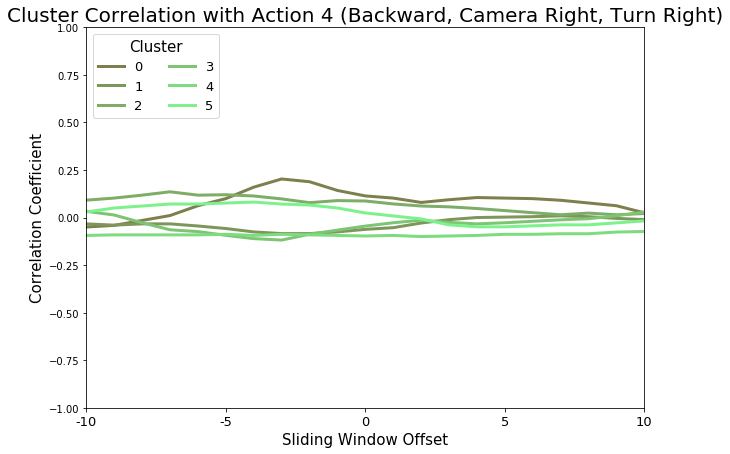

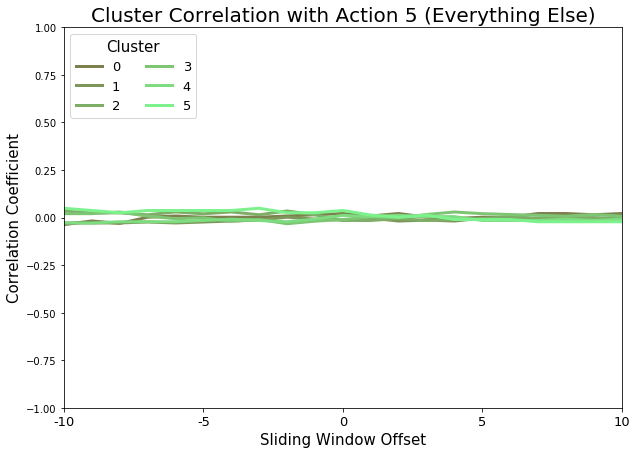

In [15]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]
corValC=np.zeros((6,num_cluster))
cormaxC = 0
corminC = 0
for action in range(6):
    corrs = np.zeros((21,num_cluster))
    for c in range(num_cluster):
        for r in range(-10,11):
            a = np.roll(all_a_comb==action, r)
            corrs[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
        if np.max(corrs[:,c])>cormaxC:cormaxC = np.max(corrs[:,c])
        if np.min(corrs[:,c])<corminC:corminC = np.min(corrs[:,c])
        corValC[action,c] = np.mean(corrs[8:13,c])
    plt.figure(figsize=(10,7))
    for c in range(num_cluster):
        #ysmoothed = gaussian_filter1d(corrs[:,c], sigma=0.5)
        plt.plot(corrs[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
    plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
    plt.title('Cluster Correlation with Action '+str(action)+' ('+actions[action]+')',fontsize=20)
    plt.xlabel('Sliding Window Offset',fontsize=15)
    plt.ylabel('Correlation Coefficient',fontsize=15)
    plt.xticks([0,5,10,15,20],['-10','-5','0','5','10'],fontsize=13)
    plt.ylim([-1,1])
    plt.xlim([0,20])
    #plt.show()
    plt.savefig(figure_path+'C_A_Corrs/C_Corrcoef20_A'+str(action)+'.png', bbox_inches='tight')

In [16]:
dfC = pd.DataFrame(columns=['Action','cluster','correlation'])
for a in range(6):
    for c in range(num_cluster):
        dfC = dfC.append({'Action':actions[a],'cluster':int(c),'correlation':corValC[a,c]},ignore_index=True)

#### Correlations Between Actions and Clusters - Comparison Example

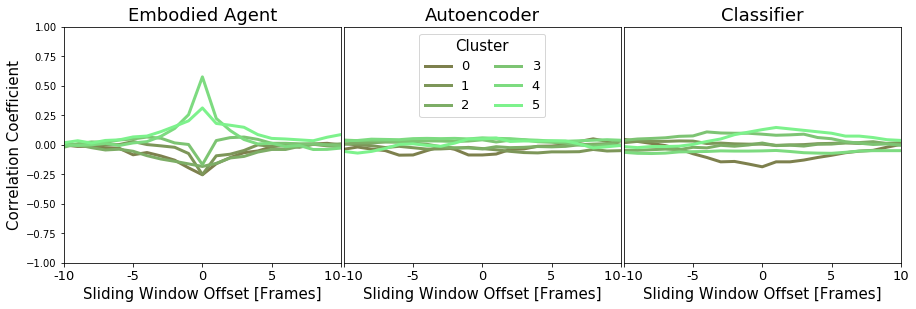

In [17]:
action = 0
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.78,wspace=0.01)

plt.subplot(1,3,1)
corrsA = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsA[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsA[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Embodied Agent',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.xticks([0,5,10,15,20],['-10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,2)
corrsAE = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsAE[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsAE[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=9,ncol=2)
plt.title('Autoencoder',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.yticks([],[])
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,3)
corrsC = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(all_a_comb==action, r)
        corrsC[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
for c in range(num_cluster):
    plt.plot(corrsC[:,c],linewidth=3,color=(0.49, 0.5+c*0.09, 0.3 + c*0.05))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Classifier',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])

#plt.suptitle('Correlation in 20 Frame Window Around Action for \nAction = '+str(actions[action]),fontsize=20)
#plt.legend(fontsize=15,bbox_to_anchor=(1.15, 0.8), loc=2)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison_Expl_A'+str(action)+'.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Overall Comparison

In [18]:
print("Embodied Agent:\nMaximum Correlation: "+str(np.round(cormaxA,3))+" Minimum Correlation: "+str(np.round(corminA,3)))
print("Autoencoder:\nMaximum Correlation: "+str(np.round(cormaxAE,3))+" Minimum Correlation: "+str(np.round(corminAE,3)))
print("Classifier:\nMaximum Correlation: "+str(np.round(cormaxC,3))+" Minimum Correlation: "+str(np.round(corminC,3)))

Embodied Agent:
Maximum Correlation: 0.795 Minimum Correlation: -0.362
Autoencoder:
Maximum Correlation: 0.146 Minimum Correlation: -0.115
Classifier:
Maximum Correlation: 0.288 Minimum Correlation: -0.186


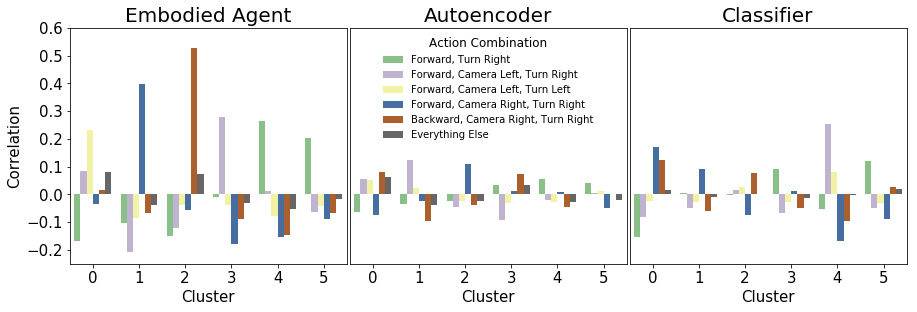

In [19]:
p = np.array(sns.color_palette("Accent", n_colors=8))[np.array([0,1,3,4,6,7])]

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.78,wspace=0.01)

plt.subplot(1,3,1)
ax = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfA,palette=p)
ax.get_legend().remove()
plt.title('Embodied Agent',fontsize=20)
plt.ylabel('Correlation',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.25,0.6)
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(1,3,2)
ax2 = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfAE,palette=p)
#ax2.get_legend().remove()
ax2.legend(fontsize=10,frameon=False,title='Action Combination',title_fontsize=12,loc=9)
plt.title('Autoencoder',fontsize=20)
plt.yticks([],[])
plt.ylim(-0.25,0.6)
plt.ylabel('')
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(1,3,3)
ax3 = sns.barplot(x="cluster", y="correlation", hue="Action", data=dfC,palette=p)
#ax3.legend(fontsize=10,frameon=False,title='Action Combination',title_fontsize=12)
ax3.get_legend().remove()
plt.title('Classifier',fontsize=20)
plt.yticks([],[])
plt.ylim(-0.25,0.6)
plt.ylabel('')

plt.ylabel('')
plt.xlabel("Cluster",fontsize=15)
plt.xticks(fontsize=15)

#plt.suptitle('Avg. Correlation in 10 Frame Window Around Action with Cluster',fontsize=22)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison.eps', bbox_inches='tight',dpi=300)

#### Correlations Between Actions and Clusters - Sum of Squared Correlations

In [20]:
sosA = np.zeros(num_cluster)#sum of squares of correlations in one cluster
for c in range(num_cluster):
    sosA[c] = np.sum(np.square(corVal[:,c]))
    
sosAE = np.zeros(num_cluster)
for c in range(num_cluster):
    sosAE[c] = np.sum(np.square(corValAE[:,c]))

sosC = np.zeros(num_cluster)
for c in range(num_cluster):
    sosC[c] = np.sum(np.square(corValC[:,c]))

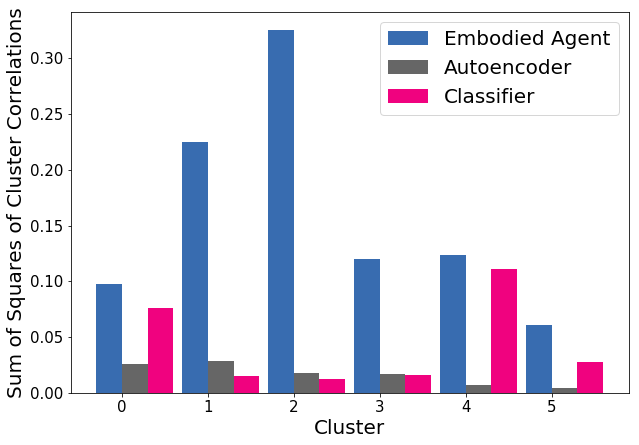

In [21]:
plt.figure(figsize=(10,7))
plt.bar(np.linspace(-0.15,4.85,6),sosA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),sosAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),sosC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Sum of Squares of Correlations\nBetween Actions and Cluster',fontsize=25)
plt.xlabel('Cluster',fontsize=20)
plt.ylabel('Sum of Squares of Cluster Correlations',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(figure_path+'Corrcoef_sum_squares.eps', bbox_inches='tight',dpi=300)

In [22]:
print('Overall sum of squares: Embodied Agent = '+str(np.round(np.sum(sosA),3))+' Autoencoder = '+str(np.round(np.sum(sosAE),3))+' Classifier = '+str(np.round(np.sum(sosC),3)))

Overall sum of squares: Embodied Agent = 0.952 Autoencoder = 0.101 Classifier = 0.258


#### Correlations Between Level Doors and Clusters

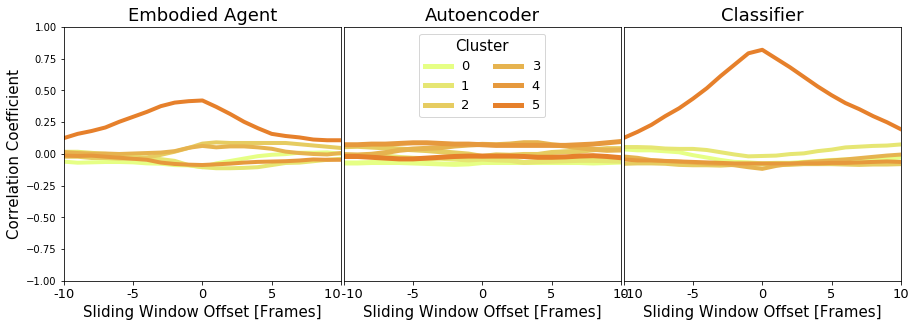

In [23]:
l_doors = label_test==6
l_doors = l_doors.astype(int)

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(top=0.83,wspace=0.01)

plt.subplot(1,3,1)
corrsA = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsA[r+10,c] = np.corrcoef((clusterA==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsA[:,c],linewidth=4,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))

#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)
plt.title('Embodied Agent',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['-10','-5','0','5','10    '],fontsize=13)
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,2)
corrsAE = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsAE[r+10,c] = np.corrcoef((clusterAE==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsAE[:,c],linewidth=5,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))

plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=9,ncol=2)
plt.title('Autoencoder',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])

plt.subplot(1,3,3)
corrsC = np.zeros((21,num_cluster))
for c in range(num_cluster):
    for r in range(-10,11):
        a = np.roll(l_doors, r)
        corrsC[r+10,c] = np.corrcoef((clusterC==c).astype(int),a)[1][0]
for c in range(num_cluster):
    r = num_cluster-c
    plt.plot(corrsC[:,c],linewidth=4,color=(0.9, 0.4+r*0.1, 0.1 + r*0.07))
#plt.legend(np.linspace(0,num_cluster-1,num_cluster,dtype=int),title='Cluster',title_fontsize=15,fontsize=13,loc=2,ncol=2)

plt.title('Classifier',fontsize=18)
plt.xlabel('Sliding Window Offset [Frames]',fontsize=15)
#plt.ylabel('Correlation Coefficient',fontsize=15)
plt.xticks([0,5,10,15,20],['    -10','-5','0','5','10'],fontsize=13)
plt.yticks([],[])
plt.ylim([-1,1])
plt.xlim([0,20])


#plt.suptitle('Correlation with Level Doors in the Visual Input',fontsize=20)
#plt.legend(fontsize=15,bbox_to_anchor=(1.15, 0.8), loc=2)
#plt.show()
plt.savefig(figure_path+'Corrcoef_Comparison_Doors.eps', bbox_inches='tight',dpi=300)

In [24]:
print("Embodied Agent:\nMaximum Correlation: "+str(np.round(np.max(corrsA),3))+" Minimum Correlation: "+str(np.round(np.min(corrsA),3)))
print("Autoencoder:\nMaximum Correlation: "+str(np.round(np.max(corrsAE),3))+" Minimum Correlation: "+str(np.round(np.min(corrsAE),3)))
print("Classifier:\nMaximum Correlation: "+str(np.round(np.max(corrsC),3))+" Minimum Correlation: "+str(np.round(np.min(corrsC),3)))

Embodied Agent:
Maximum Correlation: 0.421 Minimum Correlation: -0.113
Autoencoder:
Maximum Correlation: 0.098 Minimum Correlation: -0.082
Classifier:
Maximum Correlation: 0.82 Minimum Correlation: -0.118


### T-SNE
#### Create Mapping into 2D Space

In [25]:
tsneA = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encA)
tsneAE = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encAE)
tsneC = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encC)

#### T-SNE Colored by Image Content - Embodied Agent

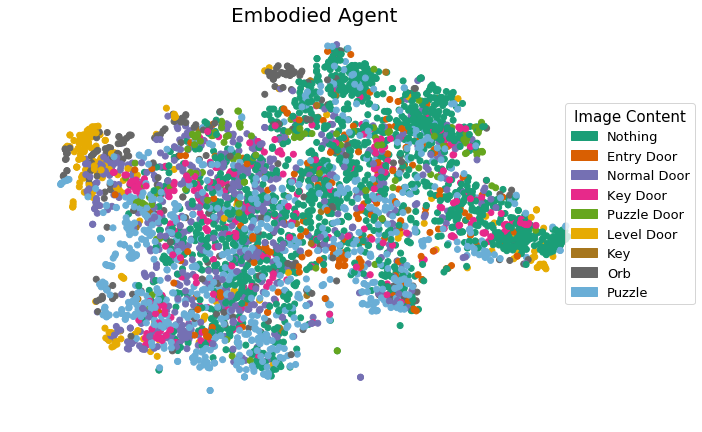

In [29]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_A.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Cluster Assignment - Embodied Agent

In [26]:
from matplotlib.colors import ListedColormap

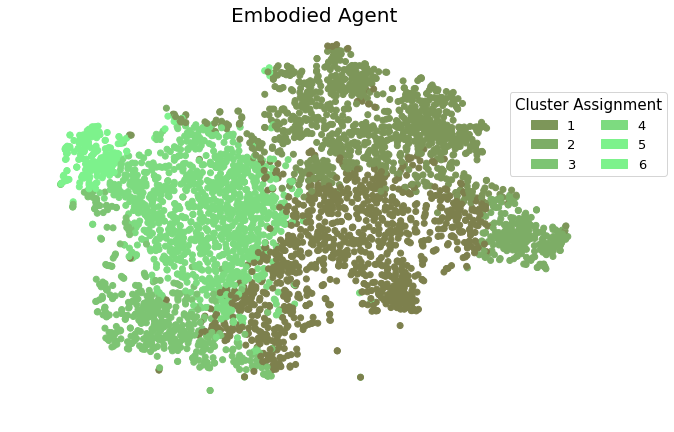

In [31]:
cmap = []
for c in range(num_cluster):
    cmap.append((0.49, 0.5+c*0.09, 0.3 + c*0.05))

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=np.array(clusterA),cmap=ListedColormap(cmap))
values = np.linspace(1,6,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=str(i+1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.85, 0.83), loc=2, borderaxespad=0. , title='Cluster Assignment',title_fontsize=15,fontsize=13,ncol=2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_cluster_A.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Image Content - Autoencoder

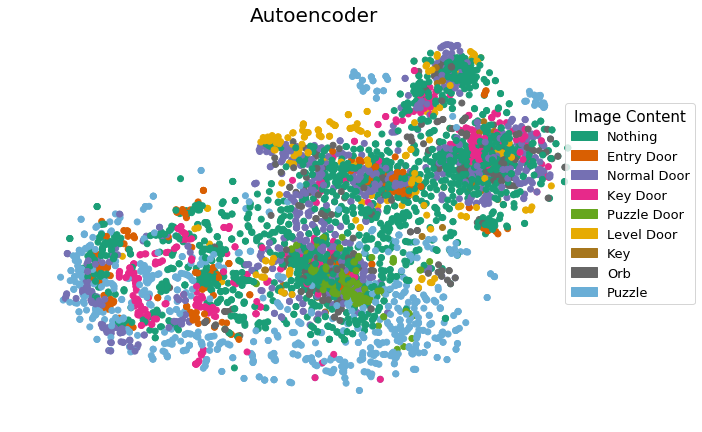

In [27]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Autoencoder', fontsize=20)
im1 = plt.scatter(tsneAE[:,0],tsneAE[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_AE.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Image Content - Classifier

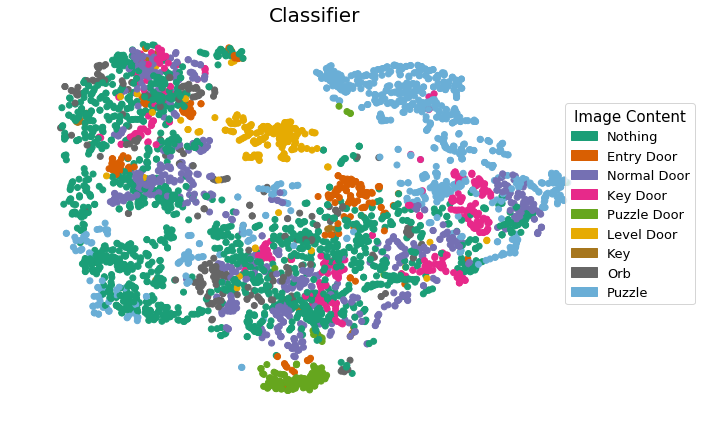

In [33]:
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 8)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Puzzle Door','Level Door','Key','Orb','Puzzle']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Classifier', fontsize=20)
im1 = plt.scatter(tsneC[:,0],tsneC[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,9,9)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_semantic_C.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Preprocessing

In [28]:
label_test = np.array(hand_l['Label'])
edgeWs = np.array(hand_l['Label'])
edgeWs[edgeWs == 0]=0
edgeWs[edgeWs == 1]=0
edgeWs[edgeWs == 2]=0
edgeWs[edgeWs == 3]=0
edgeWs[edgeWs == 4]=0
edgeWs[edgeWs == 5]=0
edgeWs[edgeWs == 6]=1
edgeWs[edgeWs == 7]=0
edgeWs[edgeWs == 8]=0
edgeWs[edgeWs == 9]=0

edgeCs = np.array(hand_l['Label'])
edgeCs = edgeCs.astype(str)
edgeCs[edgeCs=='0'] = 'b'
edgeCs[edgeCs=='1'] = 'b'
edgeCs[edgeCs=='2'] = 'b'
edgeCs[edgeCs=='3'] = 'green'
edgeCs[edgeCs=='4'] = 'firebrick'
edgeCs[edgeCs=='5'] = 'purple'
edgeCs[edgeCs=='6'] = 'r'
edgeCs[edgeCs=='7'] = 'yellow'
edgeCs[edgeCs=='8'] = 'darkblue'
edgeCs[edgeCs=='9'] = 'b'

newOrder = np.append(np.where(edgeWs==0),np.where(edgeWs!=0))#to plot door frames on top (better visibility)
edgeWs[newOrder]

act_lab = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']

#### T-SNE Colored by Action - Embodied Agent

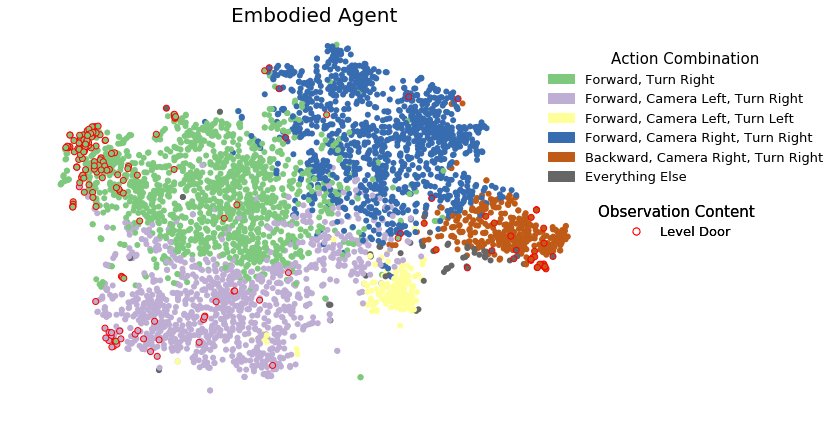

In [35]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
im1 = plt.scatter(tsneA[newOrder,0],tsneA[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_A.eps', bbox_inches='tight',dpi=300)

#### PCA Comparison

In [29]:
from sklearn.decomposition import PCA
num_comp = 2
pca_c1 = PCA(n_components=num_comp)
pca_c1.fit(encA)
pcs_c1 = pca_c1.transform(encA)

pca_c2 = PCA(n_components=num_comp)
pca_c2.fit(encAE)
pcs_c2 = pca_c2.transform(encAE)

pca_c3 = PCA(n_components=num_comp)
pca_c3.fit(encC)
pcs_c3 = pca_c3.transform(encC)

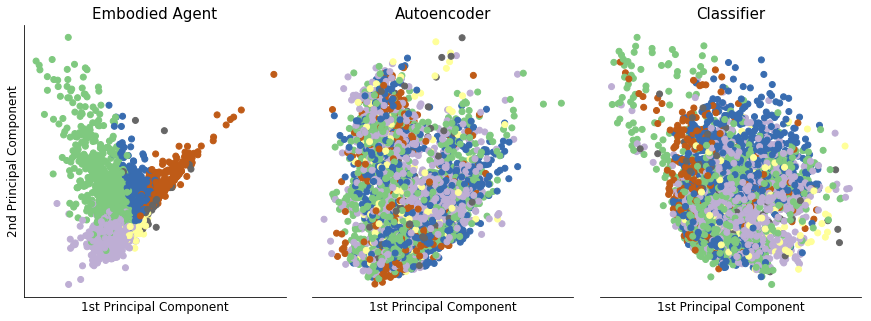

In [30]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0.1)
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(pcs_c1[:,0],pcs_c1[:,1],c=all_a_comb,cmap='Accent')
plt.title('Embodied Agent',fontsize=15)
ax1.set_ylabel('2nd Principal Component', fontsize=12)

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(pcs_c2[:,0],pcs_c2[:,1],c=all_a_comb,cmap='Accent')
plt.title('Autoencoder',fontsize=15)

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(pcs_c3[:,0],pcs_c3[:,1],c=all_a_comb,cmap='Accent')
plt.title('Classifier',fontsize=15)

for i,ax in enumerate([ax1,ax2,ax3]):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i != 0:
        ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('1st Principal Component', fontsize=12)

plt.savefig(figure_path+'PCA2_Action.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Autoencoder

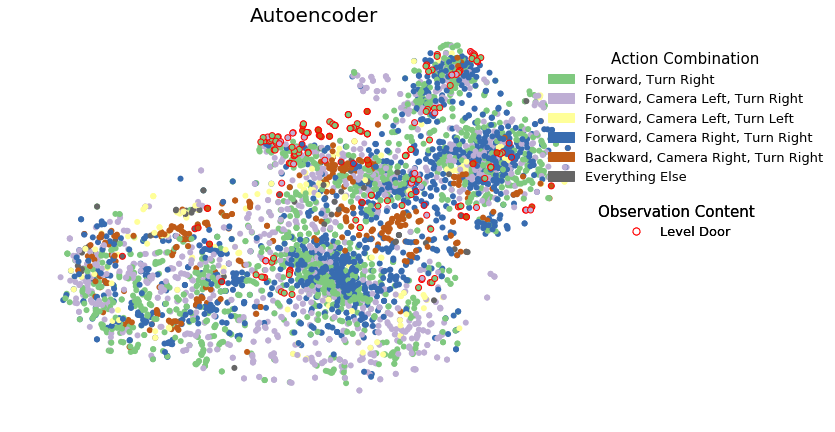

In [31]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Autoencoder', fontsize=20)
im1 = plt.scatter(tsneAE[newOrder,0],tsneAE[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_AE.eps', bbox_inches='tight',dpi=300)

#### T-SNE Colored by Action - Classifier

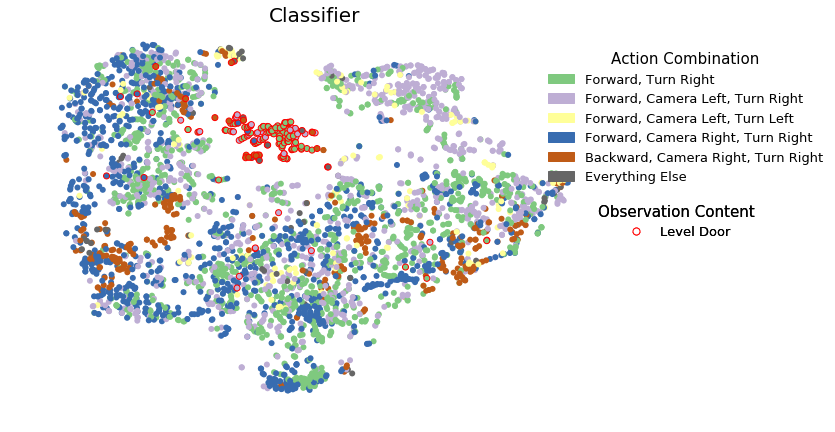

In [39]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Classifier', fontsize=20)
im1 = plt.scatter(tsneC[newOrder,0],tsneC[newOrder,1],c=all_a_comb[newOrder],cmap='Accent',edgecolors=edgeCs[newOrder],linewidths =edgeWs[newOrder])
values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
fig.add_artist(l2)

plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_actions_C.eps', bbox_inches='tight',dpi=300)

### Variance in Action Clusters

In [32]:
num_act = np.unique(all_a_comb).shape[0]
_,_,bA,wA = getClusterVariance(all_a_comb,encA,num_act)
_,_,bAE,wAE = getClusterVariance(all_a_comb,encAE,num_act)
_,_,bC,wC = getClusterVariance(all_a_comb,encC,num_act)

In [33]:
print("Embodied Agent: Between class variance: "+str(np.round(bA,4)))
print("Embodied Agent: within class variance:"+str(np.round(wA,4)))
print("Relative class variance: "+str(np.round(wA/bA,4)))
print("Average class variance: "+str(np.round(np.mean(wA/bA),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wA[:4]/bA),4))+" Last 2: "+str(np.round(np.mean(wA[4:]/bA),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wA/bA)),3)))

print("\nAutoencoder: Between class variance: "+str(np.round(bAE,4)))
print("Autoencoder: within class variance:"+str(np.round(wAE,4)))
print("Relative class variance: "+str(np.round(wAE/bAE,4)))
print("Average class variance: "+str(np.round(np.mean(wAE/bAE),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wAE[:4]/bAE),4))+" Last 2: "+str(np.round(np.mean(wAE[4:]/bAE),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wAE/bAE)),3)))

print("\nClassifier: Between class variance: "+str(np.round(bC,4)))
print("Classifier: within class variance:"+str(np.round(wC,4)))
print("Relative class variance: "+str(np.round(wC/bC,4)))
print("Average class variance: "+str(np.round(np.mean(wC/bC),4)))
print("Average class variance, class 0-4: "+str(np.round(np.mean(wC[:4]/bC),4))+" Last 2: "+str(np.round(np.mean(wC[4:]/bC),4)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-wC/bC)),3)))

Embodied Agent: Between class variance: 23.0799
Embodied Agent: within class variance:[16.6139 13.4569 14.7458  8.9584 32.4644 44.1316]
Relative class variance: [0.7198 0.5831 0.6389 0.3881 1.4066 1.9121]
Average class variance: 0.9414
Average class variance, class 0-4: 0.5825 Last 2: 1.6594
Mean absolute distance from 1: 0.498

Autoencoder: Between class variance: 0.0732
Autoencoder: within class variance:[0.068  0.0779 0.0914 0.0666 0.0714 0.104 ]
Relative class variance: [0.9294 1.0636 1.2479 0.9094 0.9754 1.421 ]
Average class variance: 1.0911
Average class variance, class 0-4: 1.0376 Last 2: 1.1982
Mean absolute distance from 1: 0.153

Classifier: Between class variance: 28.6903
Classifier: within class variance:[27.6705 28.9038 30.4345 26.2332 26.4527 38.5528]
Relative class variance: [0.9645 1.0074 1.0608 0.9144 0.922  1.3438]
Average class variance: 1.0355
Average class variance, class 0-4: 0.9868 Last 2: 1.1329
Mean absolute distance from 1: 0.102


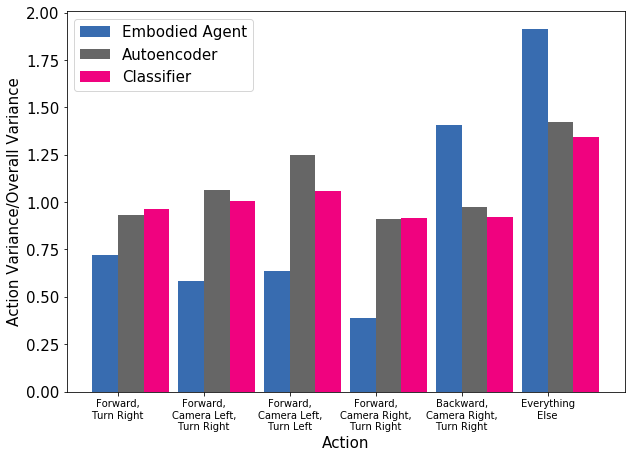

In [34]:
action_C = ['Forward,\nTurn Right','Forward,\nCamera Left,\nTurn Right','Forward,\nCamera Left,\nTurn Left',
           'Forward,\nCamera Right,\nTurn Right','Backward,\nCamera Right,\nTurn Right','Everything\nElse']

plt.figure(figsize=(10,7))
plt.bar(np.linspace(-0.15,4.85,6),wA/bA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),wAE/bAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),wC/bC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Variance within Encodings Corresponding to one Action',fontsize=20)
plt.xlabel('Action',fontsize=15)
plt.ylabel('Action Variance/Overall Variance',fontsize=15)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,5,6),action_C,fontsize=10)
plt.savefig(figure_path+'HighD_Action_Variances.eps', bbox_inches='tight',dpi=300)
#plt.show()

### Distances Within Action Clusters

In [35]:
num_act = np.unique(all_a_comb).shape[0]

allDA = getDistances(encA)
allD_varA = np.var(allDA)
allDA = np.mean(allDA)

acc_dA = np.zeros(num_act)
acc_d_varA = np.zeros(num_act)
for acc in range(num_act):
    acc_dA[acc] = np.mean(getDistances(encA[all_a_comb==acc]))
    acc_d_varA[acc] = np.var(getDistances(encA[all_a_comb==acc]))

allDAE = getDistances(encAE)
allD_varAE = np.var(allDAE)
allDAE = np.mean(allDAE)

acc_dAE = np.zeros(num_act)
acc_d_varAE = np.zeros(num_act)
for acc in range(num_act):
    acc_dAE[acc] = np.mean(getDistances(encAE[all_a_comb==acc]))
    acc_d_varAE[acc] = np.var(getDistances(encAE[all_a_comb==acc]))

allDC = getDistances(encC)
allD_varC = np.var(allDC)
allDC = np.mean(allDC)

acc_dC = np.zeros(num_act)
acc_d_varC = np.zeros(num_act)
for acc in range(num_act):
    acc_dC[acc] = np.mean(getDistances(encC[all_a_comb==acc]))
    acc_d_varC[acc] = np.var(getDistances(encC[all_a_comb==acc]))


In [36]:
print("Embodied Agent:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dA)/allDA,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dA[:4])/allDA,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dA[4:])/allDA,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dA/allDA)),3)))

print("Autoencoder:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dAE)/allDAE,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dAE[:4])/allDAE,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dAE[4:])/allDAE,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dAE/allDAE)),3)))

print("Classifier:")
print("Average distance within action clusters/overall distances: "+str(np.round(np.mean(acc_dC)/allDC,3)))
print("For first four actions: "+str(np.round(np.mean(acc_dC[:4])/allDC,3)))
print("Last two actions: "+str(np.round(np.mean(acc_dC[4:])/allDC,3)))
print("Mean absolute distance from 1: "+str(np.round(np.mean(np.abs(1-acc_dC/allDC)),3)))

Embodied Agent:
Average distance within action clusters/overall distances: 0.96
For first four actions: 0.78
Last two actions: 1.319
Mean absolute distance from 1: 0.253
Autoencoder:
Average distance within action clusters/overall distances: 1.042
For first four actions: 1.017
Last two actions: 1.093
Mean absolute distance from 1: 0.074
Classifier:
Average distance within action clusters/overall distances: 1.015
For first four actions: 0.993
Last two actions: 1.059
Mean absolute distance from 1: 0.05


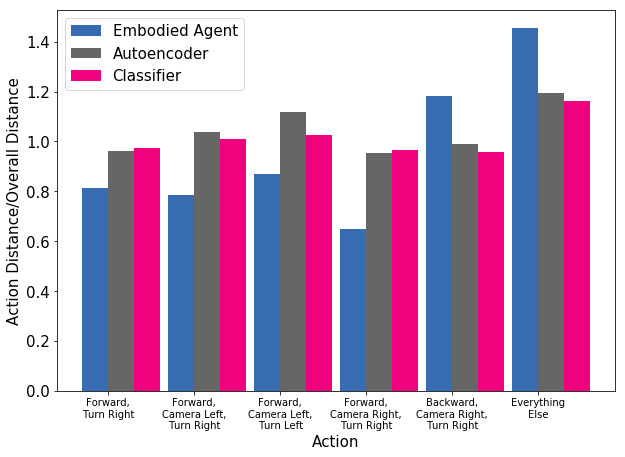

In [37]:
action_C = ['Forward,\nTurn Right','Forward,\nCamera Left,\nTurn Right','Forward,\nCamera Left,\nTurn Left',
           'Forward,\nCamera Right,\nTurn Right','Backward,\nCamera Right,\nTurn Right','Everything\nElse']

plt.figure(figsize=(10,7))

plt.bar(np.linspace(-0.15,4.85,6),acc_dA/allDA,width=0.3,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0.15,5.15,6),acc_dAE/allDAE,width=0.3,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.45,5.45,6),acc_dC/allDC,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])

#plt.title('Distance Within Encodings Corresponding to one Action',fontsize=20)
plt.xlabel('Action',fontsize=15)
plt.ylabel('Action Distance/Overall Distance',fontsize=15)
plt.legend(['Embodied Agent','Autoencoder','Classifier'],fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,5,6),action_C,fontsize=10)
plt.savefig(figure_path+'HighD_Action_Distances.eps', bbox_inches='tight',dpi=300)
#plt.show()

### Distances Between Pairs of Cluster Combinations & Cluster Distance Index (CDI)

In [38]:
acrossA = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encA[all_a_comb==c1],encA[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossA.append(acd)

0.0 - 1.0 = 88.37677544331756
0.0 - 2.0 = 115.1886156053709
0.0 - 3.0 = 87.73313555534834
0.0 - 4.0 = 148.05661635322912
0.0 - 5.0 = 140.48637336695555
1.0 - 2.0 = 106.64202965826726
1.0 - 3.0 = 92.03496187501335
1.0 - 4.0 = 145.08730091605847
1.0 - 5.0 = 134.82729300853308
2.0 - 3.0 = 101.33718664092378
2.0 - 4.0 = 142.87522853761314
2.0 - 5.0 = 133.48234486888956
3.0 - 4.0 = 126.34854945876442
3.0 - 5.0 = 126.58349841237427
4.0 - 5.0 = 142.19468446428996


In [39]:
acrossAE = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encAE[all_a_comb==c1],encAE[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossAE.append(acd)

0.0 - 1.0 = 6.0426162141795725
0.0 - 2.0 = 6.435243936328922
0.0 - 3.0 = 5.794137936809726
0.0 - 4.0 = 6.011458781939406
0.0 - 5.0 = 6.633966023375703
1.0 - 2.0 = 6.6022487364849365
1.0 - 3.0 = 6.050523329123377
1.0 - 4.0 = 6.269279524958747
1.0 - 5.0 = 6.841086240153811
2.0 - 3.0 = 6.439282192089081
2.0 - 4.0 = 6.52661613149536
2.0 - 5.0 = 7.06354720465563
3.0 - 4.0 = 6.005743446483256
3.0 - 5.0 = 6.6157543229869935
4.0 - 5.0 = 6.649460471418488


In [40]:
acrossC = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossD(encC[all_a_comb==c1],encC[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    acrossC.append(acd)

0.0 - 1.0 = 118.13896553169
0.0 - 2.0 = 120.99869650092555
0.0 - 3.0 = 116.37244408428163
0.0 - 4.0 = 118.29562568771324
0.0 - 5.0 = 129.58641399616045
1.0 - 2.0 = 121.67151606335212
1.0 - 3.0 = 118.99550309398491
1.0 - 4.0 = 122.10964365070369
1.0 - 5.0 = 130.86333220422867
2.0 - 3.0 = 121.29592924759238
2.0 - 4.0 = 124.4232108583412
2.0 - 5.0 = 130.90125734585303
3.0 - 4.0 = 117.38659270313218
3.0 - 5.0 = 128.33260070126482
4.0 - 5.0 = 128.9617819896185


In [41]:
withinA = np.mean(acc_dA)
withinAE = np.mean(acc_dAE)
withinC = np.mean(acc_dC)
print('Average Distance within Clusters - Embodied Agent: '+str(withinA))
print('Average Distance within Clusters - Autoencoder: '+str(withinAE))
print('Average Distance within Clusters - Classifier: '+str(withinC))

Average Distance within Clusters - Embodied Agent: 91.3866435667792
Average Distance within Clusters - Autoencoder: 6.269854148106148
Average Distance within Clusters - Classifier: 119.80873397859484


In [42]:
acrossAllA = np.mean(acrossA)
acrossAllAE = np.mean(acrossAE)
acrossAllC = np.mean(acrossC)
print('Average Distance across all Cluster Combinations - Embodied Agent: '+str(acrossAllA))
print('Average Distance across all Cluster Combinations - Autoencoder: '+str(acrossAllAE))
print('Average Distance across all Cluster Combinations - Classifier: '+str(acrossAllC))

Average Distance across all Cluster Combinations - Embodied Agent: 122.0836396109966
Average Distance across all Cluster Combinations - Autoencoder: 6.398730966165534
Average Distance across all Cluster Combinations - Classifier: 123.22223424392284


In [43]:
CDI_A = (acrossAllA-withinA)/allDA
CDI_AE = (acrossAllAE-withinAE)/allDAE
CDI_C = (acrossAllC-withinC)/allDC
print('Cluster Distance Index (CDI) - Embodied Agent: '+str(CDI_A))
print('Cluster Distance Index (CDI) - Autoencoder: '+str(CDI_AE))
print('Cluster Distance Index (CDI) - Classifier: '+str(CDI_C))

Cluster Distance Index (CDI) - Embodied Agent: 0.32237646037925616
Cluster Distance Index (CDI) - Autoencoder: 0.021424756039766957
Cluster Distance Index (CDI) - Classifier: 0.028929211777108735


### Cluster Correlations & Cluster Correlation Index (CCI)

In [44]:
allD_cA = getCorDistances(encA)
allD_cA = np.mean(allD_cA)
print('Embodied Agent - Overall Correlation Distances: '+str(allD_cA))

acc_d_cA = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cA[acc] = np.mean(getCorDistances(encA[all_a_comb==acc]))
print('Embodied Agent - Cluster Distances: '+str(acc_d_cA))

allD_cAE = getCorDistances(encAE)
allD_cAE = np.mean(allD_cAE)
print('Autoencoder - Overall Correlation Distances: '+str(allD_cAE))

acc_d_cAE = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cAE[acc] = np.mean(getCorDistances(encAE[all_a_comb==acc]))
print('Autoencoder - Cluster Distances: '+str(acc_d_cAE))

allD_cC = getCorDistances(encC)
allD_cC = np.mean(allD_cC)
print('Classifier - Overall Correlation Distances: '+str(allD_cC))

acc_d_cC = np.zeros(num_act)
for acc in range(num_act):
    acc_d_cC[acc] = np.mean(getCorDistances(encC[all_a_comb==acc]))
print('Classifier - Cluster Distances: '+str(acc_d_cC))

within_cA = np.mean(acc_d_cA)
within_cAE = np.mean(acc_d_cAE)
within_cC = np.mean(acc_d_cC)
within4_cA = np.mean(acc_d_cA[:4])

across_corA = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encA[all_a_comb==c1],encA[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corA.append(acd)
acrossAll_cA = np.mean(across_corA)
print('Embodied Agent - Across Correlation Distance (Avg): '+str(acrossAll_cA))
    
across_corAE = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encAE[all_a_comb==c1],encAE[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corAE.append(acd)
acrossAll_cAE = np.mean(across_corAE)
print('Autoencoder - Across Correlation Distance (Avg): '+str(acrossAll_cAE))

across_corC = []
for c1,c2 in combinations(np.linspace(0,5,6), 2):
    acd = np.mean(getAcrossCorD(encC[all_a_comb==c1],encC[all_a_comb==c2]))
    print(str(c1)+' - '+str(c2)+' = '+str(acd))
    across_corC.append(acd)
acrossAll_cC = np.mean(across_corC)
print('Classifier - Across Correlation Distance (Avg): '+str(acrossAll_cC))
    
print('CCI (corr-dist) - Embodied Agent: '+str((acrossAll_cA-within_cA)/allD_cA))
print('CCI (corr-dist) - Autoencoder: '+str((acrossAll_cAE-within_cAE)/allD_cAE))
print('CCI (corr-dist) - Classifier: '+str((acrossAll_cC-within_cC)/allD_cC))

Embodied Agent - Overall Correlation Distances: 0.6765368116260169
Embodied Agent - Cluster Distances: [0.3361146  0.44061131 0.44806158 0.48745281 0.31786979 0.64782569]
Autoencoder - Overall Correlation Distances: 0.2368986649035953
Autoencoder - Cluster Distances: [0.21770222 0.24892099 0.28303006 0.21900342 0.24748789 0.31914468]
Classifier - Overall Correlation Distances: 0.8033572518628754
Classifier - Cluster Distances: [0.77426398 0.79106433 0.77502578 0.78569161 0.74063639 0.83790591]
0.0 - 1.0 = 0.5637933640937131
0.0 - 2.0 = 0.9369249589559191
0.0 - 3.0 = 0.6954508676521799
0.0 - 4.0 = 0.9617965819216713
0.0 - 5.0 = 0.9486487422175248
1.0 - 2.0 = 0.8627901434776417
1.0 - 3.0 = 0.8864256006380832
1.0 - 4.0 = 0.9838772416008948
1.0 - 5.0 = 0.923997131146651
2.0 - 3.0 = 0.9314718380287985
2.0 - 4.0 = 0.8697216463614568
2.0 - 5.0 = 0.822368595557956
3.0 - 4.0 = 0.7835675041951382
3.0 - 5.0 = 0.91083408761266
4.0 - 5.0 = 0.633377788148358
Embodied Agent - Across Correlation Dista

### Distances Between 'Level Door' and 'No Level Door' Frames

In [45]:
label_test = np.array(hand_l['Label'])
doorFrames = label_test
doorFrames[doorFrames!=6] = 0
doorFrames[doorFrames==6] = 1

In [46]:
doorDA = getDistances(encA[doorFrames==1])
noDoorDA = getDistances(encA[doorFrames==0])

doorDAE = getDistances(encAE[doorFrames==1])
noDoorDAE = getDistances(encAE[doorFrames==0])

doorDC = getDistances(encC[doorFrames==1])
noDoorDC = getDistances(encC[doorFrames==0])

In [47]:
print("Embodied Agent")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDA)/allDA,3))+" Var = "+str(np.round(np.var(doorDA),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDA)/allDA,3))+" Var = "+str(np.round(np.var(noDoorDA),3)))

print("Autoencoder")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDAE)/allDAE,3))+" Var = "+str(np.round(np.var(doorDAE),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDAE)/allDAE,3))+" Var = "+str(np.round(np.var(noDoorDAE),3)))

print("Classifier")
print("Door frames: Average Distance = "+str(np.round(np.mean(doorDC)/allDC,3))+" Var = "+str(np.round(np.var(doorDC),3)))
print("No Door frames: Average Distance = "+str(np.round(np.mean(noDoorDC)/allDC,3))+" Var = "+str(np.round(np.var(noDoorDC),3)))

Embodied Agent
Door frames: Average Distance = 2.025 Var = 9135.037
No Door frames: Average Distance = 0.923 Var = 1835.446
Autoencoder
Door frames: Average Distance = 1.039 Var = 2.461
No Door frames: Average Distance = 0.996 Var = 1.27
Classifier
Door frames: Average Distance = 1.093 Var = 918.47
No Door frames: Average Distance = 0.972 Var = 609.468


## Extracting Object Encodings

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn import svm

Using TensorFlow backend.
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\py

In [5]:
def addLabel(currL,ToAdd):
    if ToAdd<=1:
        return currL
    elif ToAdd==2:
        currL[0] = 4
    elif ToAdd==3:
        currL[0] = 2
    elif ToAdd==4:
        currL[0] = 3
    elif ToAdd==5:
        currL[0] = 4
    elif ToAdd==6:
        currL[0]=1
    elif ToAdd==7:
        currL[1]=1
    elif ToAdd==8:
        currL[2]=1
    elif ToAdd==9:
        currL[3]=1
    else:
        print(ToAdd)
    return currL

def formatLabels(labels1,labels2):
    formatted = []
    for i,l in enumerate(labels1):
        newLabel=[0,0,0,0]
        if l == 0:
            print(i)
        newLabel = addLabel(newLabel,l)
        #print(str(i)+': '+str(newLabel)+ '  '+str(l))
        newLabel = addLabel(newLabel,labels2[i])
        #print(str(i)+': '+str(newLabel)+ '  '+str(labels2[i]))
        formatted.append(newLabel)
    return np.array(formatted)
def getFP_FN(o,l):
    w = np.where(l!=o)
    FN = np.sum((o[w]==0)&(l[w]==1))/len(w[0])*100
    FP = np.sum((o[w]>0)&(l[w]==0))/len(w[0])*100
    return np.round(FP,3),np.round(FN,3)

def getAccPR(o,l):
    w = np.where(l!=o)
    trueP = np.sum((o==l)&(o==1))
    trueN = np.sum((o==l)&(o==0))
    falseP = np.sum((o[w]>0)&(l[w]==0))
    falseN = np.sum((o[w]==0)&(l[w]==1))
    Acc = (trueP+trueN)/len(o)*100
    Precision = np.nan_to_num(trueP/(trueP+falseP)*100)
    Recall = np.nan_to_num(trueP/(trueP+falseN)*100)
    F1Score = np.nan_to_num(2 * ((Precision * Recall) / (Precision + Recall)))
    return np.round(Acc,3),np.round(Precision,3),np.round(Recall,3), F1Score, [trueP,trueN,falseP,falseN]

def printPerformance(out,fLabels,getStats=False):
    print('Accuracy: '+str(np.mean(out==fLabels)*100)+'%')
    print('Everything correct in '+str(np.sum(np.mean(out==fLabels,axis=1)==1.0)/len(fLabels)*100)+'%')
    print('Correct Door in '+str(np.round(np.mean(np.array(fLabels)[:,0]==out[:,0])*100,3))+'%')

    AccND,PND,RND,FND,NDA = getAccPR((out[:,0]==0).astype(int),(fLabels[:,0]==0).astype(int))
    print('     No Door - Acc: '+str(AccND)+'% Precision: '+str(PND)+'% Recall: '+str(RND)+
          '% F1 Score: '+ str(FND)+'%  |  TP,TN,FP,FN: '+str(NDA))

    AccLD,PLD,RLD,FLD,LDA = getAccPR((out[:,0]==1).astype(int),(fLabels[:,0]==1).astype(int))
    print('     Level Door - Acc: '+str(AccLD)+'% Precision: '+str(PLD)+'% Recall: '+str(RLD)+
          '% F1 Score: '+ str(FLD)+'%  |  TP,TN,FP,FN: '+str(LDA))

    AccGD,PGD,RGD,FGD,GDA = getAccPR((out[:,0]==2).astype(int),(fLabels[:,0]==2).astype(int))
    print('     Green Door - Acc: '+str(AccGD)+'% Precision: '+str(PGD)+'% Recall: '+str(RGD)+
          '% F1 Score: '+ str(FGD)+'%  |  TP,TN,FP,FN: '+str(GDA))

    AccKD,PKD,RKD,FKD,KDA = getAccPR((out[:,0]==3).astype(int),(fLabels[:,0]==3).astype(int))
    print('     Key Door - Acc: '+str(AccKD)+'% Precision: '+str(PKD)+'% Recall: '+str(RKD)+
          '% F1 Score: '+ str(FKD)+'%  |  TP,TN,FP,FN: '+str(KDA))

    AccOD,POD,ROD,FOD,ODA = getAccPR((out[:,0]==4).astype(int),(fLabels[:,0]==4).astype(int))
    print('     Other Door - Acc: '+str(AccOD)+'% Precision: '+str(POD)+'% Recall: '+str(ROD)+
          '% F1 Score: '+ str(FOD)+'%  |  TP,TN,FP,FN: '+str(ODA))

    AccK,PK,RK,FK,KA = getAccPR(out[:,1],np.array(fLabels)[:,1])
    print('Correct Key in '+str(AccK)+'% - Precision: '+
          str(PK)+'% Recall: '+ str(RK) +
          '% F1 Score: '+ str(FK)+str(RK)+'%  |  TP,TN,FP,FN: '+str(KA))

    AccO,PO,RO,FO,OA = getAccPR(out[:,2],np.array(fLabels)[:,2])
    print('Correct Orb in '+str(AccO)+'% - Precision: '+
          str(PO)+'% Recall: '+ str(RO) +
          '% F1 Score: '+ str(FO)+str(RO)+'%  |  TP,TN,FP,FN: '+str(OA))

    AccP,PP,RP,FP,PA = getAccPR(out[:,3],np.array(fLabels)[:,3])
    print('Correct Puzzle in '+str(AccP)+'% - Precision: '+
          str(PP)+'% Recall: '+ str(RP) +
          '% F1 Score: '+ str(FP)+str(RP)+'%  |  TP,TN,FP,FN: '+str(PA))
    if getStats:
        AllAcc = np.array([AccND,AccLD,AccGD,AccKD,AccOD,AccK,AccO,AccP])
        AllP = np.array([PND,PLD,PGD,PKD,POD,PK,PO,PP])
        AllR = np.array([RND,RLD,RGD,RKD,ROD,RK,RO,RP])
        AllF1 = np.array([FND,FLD,FGD,FKD,FOD,FK,FO,FP])
        return AllAcc, AllP, AllR, AllF1

In [6]:
balancedTestSetPath = './Results/TowerTraining/BalancedTestSetAll/'

trainEncA = np.load(balancedTestSetPath + 'EncExt.npy')
trainEncAE = np.load(balancedTestSetPath + 'EncAE.npy')
trainEncC = np.load(balancedTestSetPath + 'EncC.npy')
trainEncR = np.random.randint(0,2,trainEncA.shape)
trainLabels = np.load(balancedTestSetPath + 'labels.npy')
trainClassOut = np.load(balancedTestSetPath + 'ClassOut.npy')

fLabels = formatLabels(np.array(hand_l['Label']),np.array(hand_l['Secondary label']))

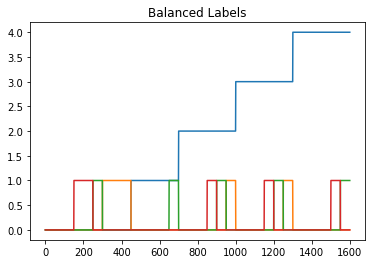

In [7]:
plt.plot(trainLabels)
plt.title('Balanced Labels')
plt.show()

In [52]:
out_A = np.zeros(fLabels.shape)
for i in range(4):
    svm_An = svm.SVC(kernel='linear')
    svm_An.fit(trainEncA, trainLabels[:,i])
    out_An = svm_An.predict(encA)
    out_A[:,i] = out_An

In [53]:
out_AB = np.zeros(fLabels.shape)
for i in range(4):
    bc = np.bincount(trainLabels[:,i])
    Cw = trainLabels[:,i].shape[0] / (bc.shape[0] * bc)
    print(Cw)
    if i>0:
        svm_An = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1]})
    else:
        svm_An = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1], 2: Cw[2], 3: Cw[3], 4: Cw[4]})
    svm_An.fit(trainEncA, trainLabels[:,i])
    out_An = svm_An.predict(encA)
    out_AB[:,i] = out_An

[0.71111111 1.28       1.06666667 1.06666667 1.06666667]
[0.59259259 3.2       ]
[0.59259259 3.2       ]
[0.59259259 3.2       ]


In [54]:
out_AE = np.zeros(fLabels.shape)
for i in range(4):
    svm_AEn = svm.SVC(kernel='linear')
    svm_AEn.fit(trainEncAE, trainLabels[:,i])
    out_AEn = svm_AEn.predict(encAE)
    out_AE[:,i] = out_AEn

In [55]:
out_AEB = np.zeros(fLabels.shape)
for i in range(4):
    bc = np.bincount(trainLabels[:,i])
    Cw = trainLabels[:,i].shape[0] / (bc.shape[0] * bc)
    if i>0:
        svm_AEn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1]})
    else:
        svm_AEn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1], 2: Cw[2], 3: Cw[3], 4: Cw[4]})
    svm_AEn.fit(trainEncAE, trainLabels[:,i])
    out_AEn = svm_AEn.predict(encAE)
    out_AEB[:,i] = out_AEn

In [56]:
out_C = np.zeros(fLabels.shape)
for i in range(4):
    svm_Cn = svm.SVC(kernel='linear')
    svm_Cn.fit(trainEncC, trainLabels[:,i])
    out_Cn = svm_Cn.predict(encC)
    out_C[:,i] = out_Cn

In [57]:
out_CB = np.zeros(fLabels.shape)
for i in range(4):
    bc = np.bincount(trainLabels[:,i])
    Cw = trainLabels[:,i].shape[0] / (bc.shape[0] * bc)
    if i>0:
        svm_Cn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1]})
    else:
        svm_Cn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1], 2: Cw[2], 3: Cw[3], 4: Cw[4]})
    svm_Cn.fit(trainEncC, trainLabels[:,i])
    out_Cn = svm_Cn.predict(encC)
    out_CB[:,i] = out_Cn

In [58]:
encR = np.random.randint(0,2,encA.shape)
out_R = np.zeros(fLabels.shape)
for i in range(4):
    svm_Rn = svm.SVC(kernel='linear')
    svm_Rn.fit(trainEncR, trainLabels[:,i])
    out_Rn = svm_Rn.predict(encR)
    out_R[:,i] = out_Rn

In [59]:
encR = np.random.randint(0,2,encA.shape)
out_RB = np.zeros(fLabels.shape)
for i in range(4):
    bc = np.bincount(trainLabels[:,i])
    Cw = trainLabels[:,i].shape[0] / (bc.shape[0] * bc)
    if i>0:
        svm_Rn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1]})
    else:
        svm_Rn = svm.SVC(kernel='linear', class_weight={0:Cw[0], 1: Cw[1], 2: Cw[2], 3: Cw[3], 4: Cw[4]})
    svm_Rn.fit(trainEncR, trainLabels[:,i])
    out_Rn = svm_Rn.predict(encR)
    out_RB[:,i] = out_Rn

In [60]:
printPerformance(trainClassOut,trainLabels)

Accuracy: 87.90625%
Everything correct in 63.5%
Correct Door in 78.0%
     No Door - Acc: 89.688% Precision: 82.167% Recall: 80.889% F1 Score: 81.52295632698768%  |  TP,TN,FP,FN: [364, 1071, 79, 86]
     Level Door - Acc: 95.562% Precision: 89.083% Recall: 81.6% F1 Score: 85.17745302713988%  |  TP,TN,FP,FN: [204, 1325, 25, 46]
     Green Door - Acc: 88.0% Precision: 63.568% Recall: 84.333% F1 Score: 72.49283667621776%  |  TP,TN,FP,FN: [253, 1155, 145, 47]
     Key Door - Acc: 88.5% Precision: 72.835% Recall: 61.667% F1 Score: 66.78700361010831%  |  TP,TN,FP,FN: [185, 1231, 69, 115]
     Other Door - Acc: 94.25% Precision: 87.681% Recall: 80.667% F1 Score: 84.02777777777777%  |  TP,TN,FP,FN: [242, 1266, 34, 58]
Correct Key in 85.0% - Precision: 55.952% Recall: 18.8% F1 Score: 28.14371257485029818.8%  |  TP,TN,FP,FN: [47, 1313, 37, 203]
Correct Orb in 91.188% - Precision: 76.077% Recall: 63.6% F1 Score: 69.2810457516339863.6%  |  TP,TN,FP,FN: [159, 1300, 50, 91]
Correct Puzzle in 97.438%

In [61]:
Acc_A, P_A, R_A, F1_A = printPerformance(out_A,fLabels,getStats=True)

Accuracy: 78.20625%
Everything correct in 33.324999999999996%
Correct Door in 47.975%
     No Door - Acc: 66.6% Precision: 74.138% Recall: 55.497% F1 Score: 63.477310005467466%  |  TP,TN,FP,FN: [1161, 1503, 405, 931]
     Level Door - Acc: 92.625% Precision: 33.908% Recall: 64.481% F1 Score: 44.44444444444445%  |  TP,TN,FP,FN: [118, 3587, 230, 65]
     Green Door - Acc: 72.625% Precision: 38.196% Recall: 38.845% F1 Score: 38.51768669286918%  |  TP,TN,FP,FN: [343, 2562, 555, 540]
     Key Door - Acc: 79.975% Precision: 25.232% Recall: 44.393% F1 Score: 32.17612193056731%  |  TP,TN,FP,FN: [190, 3009, 563, 238]
     Other Door - Acc: 84.125% Precision: 24.598% Recall: 25.845% F1 Score: 25.20612485276796%  |  TP,TN,FP,FN: [107, 3258, 328, 307]
Correct Key in 94.725% - Precision: 2.162% Recall: 11.765% F1 Score: 3.652968036529680611.765%  |  TP,TN,FP,FN: [4, 3785, 181, 30]
Correct Orb in 92.15% - Precision: 42.449% Recall: 37.545% F1 Score: 39.8467432950191537.545%  |  TP,TN,FP,FN: [104, 35

In [62]:
Acc_AB, P_AB, R_AB, F1_AB = printPerformance(out_AB,fLabels,getStats=True)

Accuracy: 60.56875%
Everything correct in 11.4%
Correct Door in 46.45%
     No Door - Acc: 65.975% Precision: 76.777% Recall: 50.096% F1 Score: 60.630604570436795%  |  TP,TN,FP,FN: [1048, 1591, 317, 1044]
     Level Door - Acc: 92.75% Precision: 35.014% Recall: 68.306% F1 Score: 46.29629629629629%  |  TP,TN,FP,FN: [125, 3585, 232, 58]
     Green Door - Acc: 72.475% Precision: 38.453% Recall: 41.11% F1 Score: 39.737274220032845%  |  TP,TN,FP,FN: [363, 2536, 581, 520]
     Key Door - Acc: 78.85% Precision: 24.819% Recall: 48.131% F1 Score: 32.75039745627981%  |  TP,TN,FP,FN: [206, 2948, 624, 222]
     Other Door - Acc: 82.85% Precision: 23.016% Recall: 28.019% F1 Score: 25.2723311546841%  |  TP,TN,FP,FN: [116, 3198, 388, 298]
Correct Key in 55.675% - Precision: 1.506% Recall: 79.412% F1 Score: 2.95566502463054279.412%  |  TP,TN,FP,FN: [27, 2200, 1766, 7]
Correct Orb in 85.5% - Precision: 25.041% Recall: 54.874% F1 Score: 34.3891402714932154.874%  |  TP,TN,FP,FN: [152, 3268, 455, 125]
Cor

In [63]:
Acc_AE, P_AE, R_AE, F1_AE = printPerformance(out_AE,fLabels,getStats=True)

Accuracy: 71.0%
Everything correct in 22.85%
Correct Door in 45.375%
     No Door - Acc: 49.575% Precision: 51.085% Recall: 84.369% F1 Score: 63.638002523886776%  |  TP,TN,FP,FN: [1765, 218, 1690, 327]
     Level Door - Acc: 95.35% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3814, 3, 183]
     Green Door - Acc: 77.925% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3117, 0, 883]
     Key Door - Acc: 88.0% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3520, 52, 428]
     Other Door - Acc: 79.9% Precision: 10.204% Recall: 12.077% F1 Score: 11.061946902654867%  |  TP,TN,FP,FN: [50, 3146, 440, 364]
Correct Key in 99.1% - Precision: 0.0% Recall: 0.0% F1 Score: 0.00.0%  |  TP,TN,FP,FN: [0, 3964, 2, 34]
Correct Orb in 63.175% - Precision: 4.421% Recall: 20.939% F1 Score: 7.30018879798615520.939%  |  TP,TN,FP,FN: [58, 2469, 1254, 219]
Correct Puzzle in 76.35% - Precision: 34.921% Recall: 7.424% F1 Score: 12.2448979591836737.424%  |  TP,

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


In [64]:
Acc_AEB, P_AEB, R_AEB, F1_AEB = printPerformance(out_AEB,fLabels,getStats=True)

Accuracy: 76.21875%
Everything correct in 28.849999999999998%
Correct Door in 43.875%
     No Door - Acc: 49.75% Precision: 51.265% Recall: 79.398% F1 Score: 62.30307576894224%  |  TP,TN,FP,FN: [1661, 329, 1579, 431]
     Level Door - Acc: 95.3% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3812, 5, 183]
     Green Door - Acc: 77.925% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3117, 0, 883]
     Key Door - Acc: 89.05% Precision: 0.0% Recall: 0.0% F1 Score: 0.0%  |  TP,TN,FP,FN: [0, 3562, 10, 428]
     Other Door - Acc: 75.725% Precision: 12.617% Recall: 22.705% F1 Score: 16.22088006902502%  |  TP,TN,FP,FN: [94, 2935, 651, 320]
Correct Key in 93.025% - Precision: 1.581% Recall: 11.765% F1 Score: 2.78745644599303111.765%  |  TP,TN,FP,FN: [4, 3717, 249, 30]
Correct Orb in 91.175% - Precision: 3.659% Recall: 1.083% F1 Score: 1.67130919220055721.083%  |  TP,TN,FP,FN: [3, 3644, 79, 274]
Correct Puzzle in 76.8% - Precision: 43.607% Recall: 14.961% F1 S

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


In [65]:
Acc_C, P_C, R_C, F1_C = printPerformance(out_C,fLabels,getStats=True)

Accuracy: 76.75%
Everything correct in 32.25%
Correct Door in 55.55%
     No Door - Acc: 71.95% Precision: 82.333% Recall: 59.034% F1 Score: 68.76391982182628%  |  TP,TN,FP,FN: [1235, 1643, 265, 857]
     Level Door - Acc: 95.05% Precision: 47.588% Recall: 80.874% F1 Score: 59.91902834008098%  |  TP,TN,FP,FN: [148, 3654, 163, 35]
     Green Door - Acc: 75.15% Precision: 44.272% Recall: 48.584% F1 Score: 46.32829373650109%  |  TP,TN,FP,FN: [429, 2577, 540, 454]
     Key Door - Acc: 79.5% Precision: 20.482% Recall: 31.776% F1 Score: 24.908424908424905%  |  TP,TN,FP,FN: [136, 3044, 528, 292]
     Other Door - Acc: 89.45% Precision: 49.281% Recall: 66.184% F1 Score: 56.49484536082474%  |  TP,TN,FP,FN: [274, 3304, 282, 140]
Correct Key in 76.375% - Precision: 2.798% Recall: 79.412% F1 Score: 5.40540540540540679.412%  |  TP,TN,FP,FN: [27, 3028, 938, 7]
Correct Orb in 87.5% - Precision: 29.837% Recall: 59.567% F1 Score: 39.7590361445783159.567%  |  TP,TN,FP,FN: [165, 3335, 388, 112]
Correct P

In [66]:
Acc_CB, P_CB, R_CB, F1_CB = printPerformance(out_CB,fLabels,getStats=True)

Accuracy: 76.725%
Everything correct in 32.175%
Correct Door in 55.55%
     No Door - Acc: 71.95% Precision: 82.333% Recall: 59.034% F1 Score: 68.76391982182628%  |  TP,TN,FP,FN: [1235, 1643, 265, 857]
     Level Door - Acc: 95.05% Precision: 47.588% Recall: 80.874% F1 Score: 59.91902834008098%  |  TP,TN,FP,FN: [148, 3654, 163, 35]
     Green Door - Acc: 75.15% Precision: 44.272% Recall: 48.584% F1 Score: 46.32829373650109%  |  TP,TN,FP,FN: [429, 2577, 540, 454]
     Key Door - Acc: 79.5% Precision: 20.482% Recall: 31.776% F1 Score: 24.908424908424905%  |  TP,TN,FP,FN: [136, 3044, 528, 292]
     Other Door - Acc: 89.45% Precision: 49.281% Recall: 66.184% F1 Score: 56.49484536082474%  |  TP,TN,FP,FN: [274, 3304, 282, 140]
Correct Key in 76.325% - Precision: 2.792% Recall: 79.412% F1 Score: 5.39460539460539479.412%  |  TP,TN,FP,FN: [27, 3026, 940, 7]
Correct Orb in 87.45% - Precision: 29.875% Recall: 60.289% F1 Score: 39.9521531100478560.289%  |  TP,TN,FP,FN: [167, 3331, 392, 110]
Correc

In [67]:
Acc_R, P_R, R_R, F1_R = printPerformance(out_R,fLabels,getStats=True)

Accuracy: 74.2125%
Everything correct in 19.650000000000002%
Correct Door in 27.375%
     No Door - Acc: 50.25% Precision: 53.451% Recall: 37.763% F1 Score: 44.25770308123249%  |  TP,TN,FP,FN: [790, 1220, 688, 1302]
     Level Door - Acc: 81.0% Precision: 5.132% Recall: 18.033% F1 Score: 7.990314769975787%  |  TP,TN,FP,FN: [33, 3207, 610, 150]
     Green Door - Acc: 67.85% Precision: 21.58% Recall: 17.327% F1 Score: 19.221105527638194%  |  TP,TN,FP,FN: [153, 2561, 556, 730]
     Key Door - Acc: 77.5% Precision: 10.927% Recall: 15.421% F1 Score: 12.790697674418604%  |  TP,TN,FP,FN: [66, 3034, 538, 362]
     Other Door - Acc: 78.15% Precision: 9.364% Recall: 12.802% F1 Score: 10.816326530612244%  |  TP,TN,FP,FN: [53, 3073, 513, 361]
Correct Key in 98.625% - Precision: 0.0% Recall: 0.0% F1 Score: 0.00.0%  |  TP,TN,FP,FN: [0, 3945, 21, 34]
Correct Orb in 93.075% - Precision: 0.0% Recall: 0.0% F1 Score: 0.00.0%  |  TP,TN,FP,FN: [0, 3723, 0, 277]
Correct Puzzle in 77.775% - Precision: 0.0% R

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


In [68]:
Acc_RB, P_RB, R_RB, F1_RB = printPerformance(out_RB,fLabels,getStats=True)

Accuracy: 50.393750000000004%
Everything correct in 3.5999999999999996%
Correct Door in 22.675%
     No Door - Acc: 49.575% Precision: 53.555% Recall: 27.008% F1 Score: 35.907213218938665%  |  TP,TN,FP,FN: [565, 1418, 490, 1527]
     Level Door - Acc: 75.975% Precision: 4.235% Recall: 19.672% F1 Score: 6.96999031945789%  |  TP,TN,FP,FN: [36, 3003, 814, 147]
     Green Door - Acc: 67.125% Precision: 21.046% Recall: 17.78% F1 Score: 19.2756292203806%  |  TP,TN,FP,FN: [157, 2528, 589, 726]
     Key Door - Acc: 75.675% Precision: 11.674% Recall: 19.393% F1 Score: 14.574187884108866%  |  TP,TN,FP,FN: [83, 2944, 628, 345]
     Other Door - Acc: 77.0% Precision: 10.345% Recall: 15.942% F1 Score: 12.547528517110266%  |  TP,TN,FP,FN: [66, 3014, 572, 348]
Correct Key in 62.9% - Precision: 0.947% Recall: 41.176% F1 Score: 1.851851851851851941.176%  |  TP,TN,FP,FN: [14, 2502, 1464, 20]
Correct Orb in 59.625% - Precision: 7.389% Recall: 41.877% F1 Score: 12.56090958310774241.877%  |  TP,TN,FP,FN: [

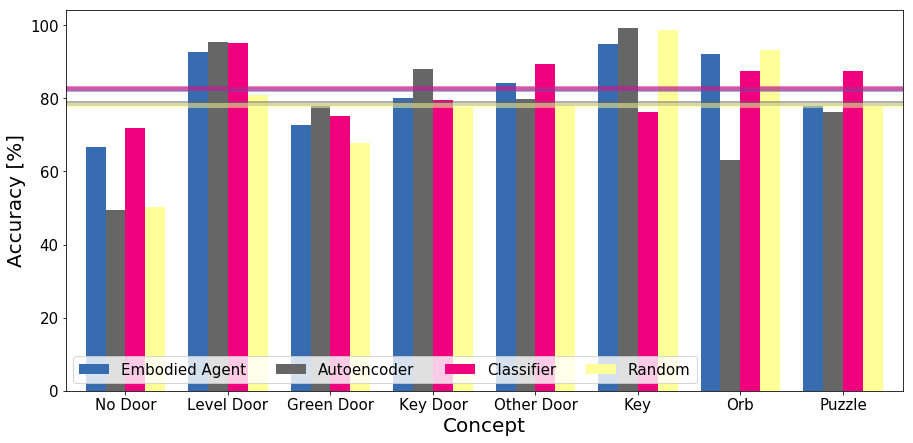

In [70]:
figure_labels = ['No Door', 'Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb', 'Puzzle']

plt.figure(figsize=(15,7))

plt.bar(np.linspace(-0.2,7,8),Acc_A,width=0.2,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0,7.2,8),Acc_AE,width=0.2,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.2,7.4,8),Acc_C,width=0.2,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.4,7.6,8),Acc_R,width=0.2,color=sns.color_palette("Accent", n_colors=8)[3])


plt.xlabel('Concept',fontsize=20)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier','Random'],fontsize=15,ncol=4,loc=3)

plt.plot([-0.5,8],[np.mean(Acc_A), np.mean(Acc_A)],color=sns.color_palette("Accent", n_colors=8)[4],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_AE), np.mean(Acc_AE)],color=sns.color_palette("Accent", n_colors=8)[7],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_C), np.mean(Acc_C)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_R), np.mean(Acc_R)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,7.9])
plt.yticks(fontsize=15)
plt.xticks(np.linspace(0.1,7.3,8),figure_labels,fontsize=15)
#plt.savefig(figure_path+'SVMAcc.eps', bbox_inches='tight',dpi=300)
plt.show()

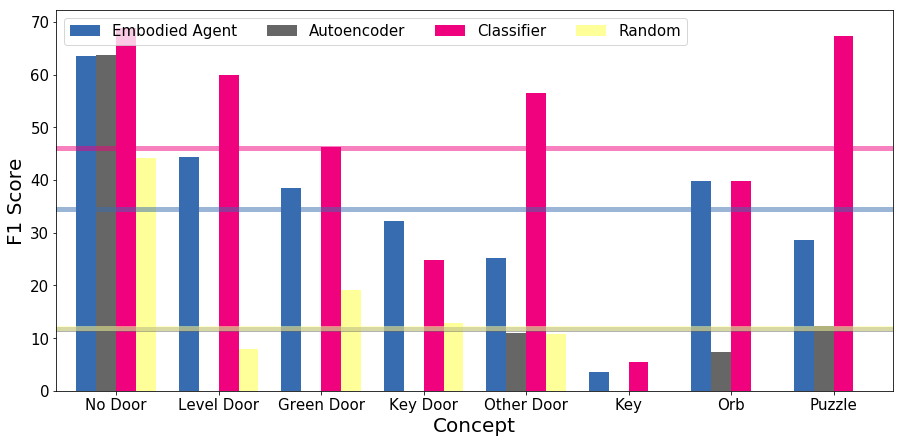

In [71]:
figure_labels = ['No Door', 'Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb', 'Puzzle']

plt.figure(figsize=(15,7))

plt.bar(np.linspace(-0.2,7,8),F1_A,width=0.2,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0,7.2,8),F1_AE,width=0.2,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.2,7.4,8),F1_C,width=0.2,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.4,7.6,8),F1_R,width=0.2,color=sns.color_palette("Accent", n_colors=8)[3])


plt.xlabel('Concept',fontsize=20)
plt.ylabel('F1 Score',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier','Random'],fontsize=15,ncol=4,loc=2)

plt.plot([-0.5,8],[np.mean(F1_A), np.mean(F1_A)],color=sns.color_palette("Accent", n_colors=8)[4],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_AE), np.mean(F1_AE)],color=sns.color_palette("Accent", n_colors=8)[7],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_C), np.mean(F1_C)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_R), np.mean(F1_R)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,7.9])
plt.yticks(fontsize=15)
plt.xticks(np.linspace(0.1,7.3,8),figure_labels,fontsize=15)
plt.savefig(figure_path+'SVMF1.eps', bbox_inches='tight',dpi=300)
#plt.show()

#### Balanced Class Weights

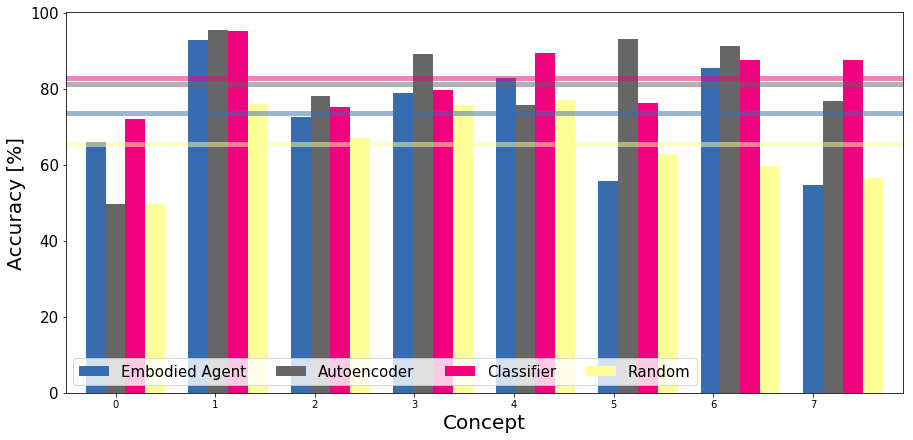

In [72]:
figure_labels = ['No Door', 'Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb', 'Puzzle']

plt.figure(figsize=(15,7))

plt.bar(np.linspace(-0.2,7,8),Acc_AB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0,7.2,8),Acc_AEB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.2,7.4,8),Acc_CB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.4,7.6,8),Acc_RB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[3])


plt.xlabel('Concept',fontsize=20)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier','Random'],fontsize=15,ncol=4,loc=3)

plt.plot([-0.5,8],[np.mean(Acc_AB), np.mean(Acc_AB)],color=sns.color_palette("Accent", n_colors=8)[4],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_AEB), np.mean(Acc_AEB)],color=sns.color_palette("Accent", n_colors=8)[7],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_CB), np.mean(Acc_CB)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_RB), np.mean(Acc_RB)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,7.9])
plt.yticks(fontsize=15)
#plt.xticks(np.linspace(0.1,7.3,8),figure_labels,fontsize=15)
plt.savefig(figure_path+'SVMAcc_CW.eps', bbox_inches='tight',dpi=300)
#plt.show()

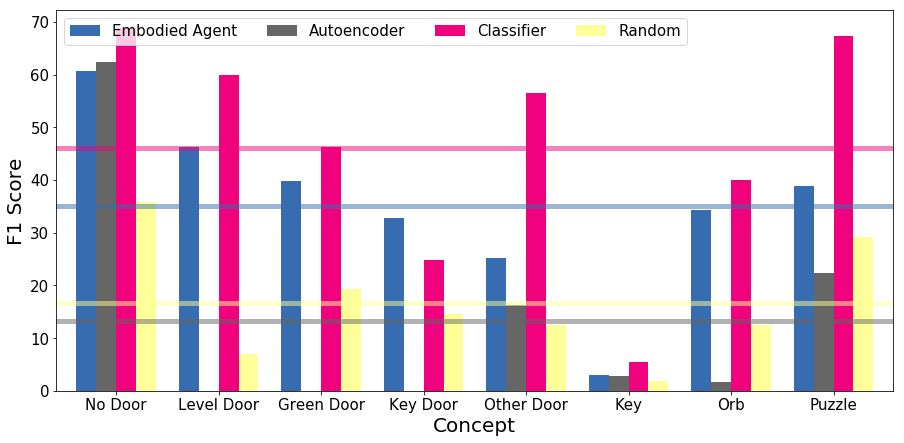

In [73]:
figure_labels = ['No Door', 'Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb', 'Puzzle']

plt.figure(figsize=(15,7))

plt.bar(np.linspace(-0.2,7,8),F1_AB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[4])
plt.bar(np.linspace(0,7.2,8),F1_AEB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[7])
plt.bar(np.linspace(0.2,7.4,8),F1_CB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.4,7.6,8),F1_RB,width=0.2,color=sns.color_palette("Accent", n_colors=8)[3])


plt.xlabel('Concept',fontsize=20)
plt.ylabel('F1 Score',fontsize=20)
plt.legend(['Embodied Agent','Autoencoder','Classifier','Random'],fontsize=15,ncol=4,loc=2)

plt.plot([-0.5,8],[np.mean(F1_AB), np.mean(F1_AB)],color=sns.color_palette("Accent", n_colors=8)[4],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_AEB), np.mean(F1_AEB)],color=sns.color_palette("Accent", n_colors=8)[7],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_CB), np.mean(F1_CB)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_RB), np.mean(F1_RB)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,7.9])
plt.yticks(fontsize=15)
plt.xticks(np.linspace(0.1,7.3,8),figure_labels,fontsize=15)
plt.savefig(figure_path+'SVMF1_CW.eps', bbox_inches='tight',dpi=300)
#plt.show()